In [84]:

import numpy as np
import matplotlib.pyplot as plt
import librosa
import sounddevice as sd
from scipy.signal import lfilter
from scipy.linalg import solve_toeplitz

# Import the filter_adaptively function
from lpctools import poly2rc, rc2lar, lar2rc, rc2poly
from filteradaptively import filter_adaptively
# Import LPC tools

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12



# =====================
# 2.0 Setup
# =====================

Loaded female8khz.wav with sampling rate: 8000 Hz
Signal duration: 2.25 seconds
Signal shape: (18000,)


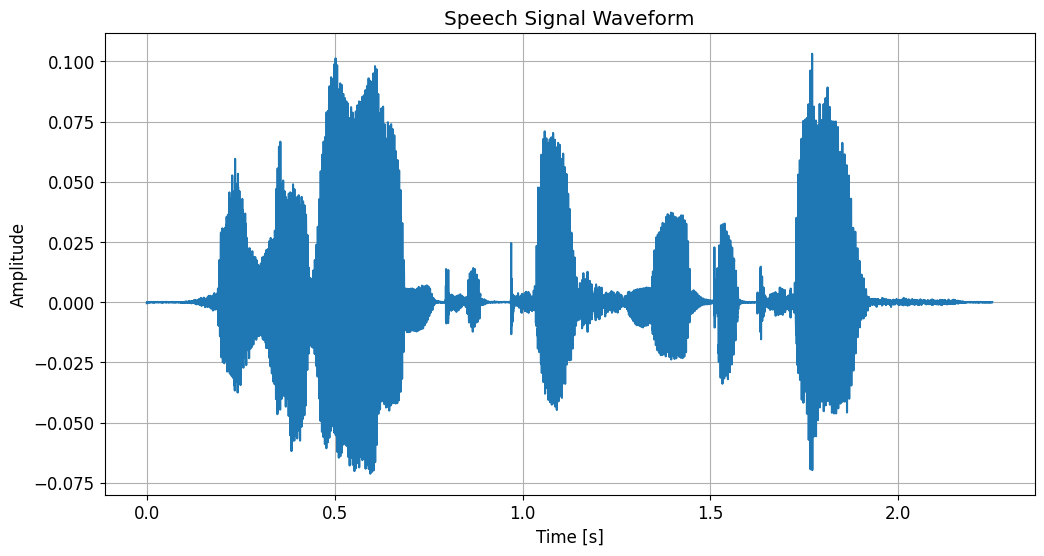

In [85]:
x, fs = librosa.load("female8khz.wav", sr=None)

# Print basic information
print(f"Loaded female8khz.wav with sampling rate: {fs} Hz")
print(f"Signal duration: {len(x)/fs:.2f} seconds")
print(f"Signal shape: {x.shape}")

# Create time vector for plotting
time = np.arange(len(x)) / fs

# Plot the waveform
plt.figure()
plt.plot(time, x)
plt.title('Speech Signal Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# =====================
# 2.1 Frame Segmentation
# =====================

In [86]:
# Define the windowing function from Exercise 1
def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length_ms: int, frame_shift_ms: int):
    """
    Splits the signal into overlapping frames.

    Parameters:
        v_signal         : Input signal (1D numpy array)
        sampling_rate    : Sampling rate in Hz
        frame_length_ms  : Frame length in milliseconds
        frame_shift_ms   : Frame shift (hop size) in milliseconds

    Returns:
        m_frames         : 2D array with one frame per row
        v_time_frame     : Time instants (center) of each frame
    """
    frame_length = int((frame_length_ms / 1000) * sampling_rate)
    frame_shift = int((frame_shift_ms / 1000) * sampling_rate)
    
    # Calculate the number of frames that fit into the signal
    num_frames = 1 + (len(v_signal) - frame_length) // frame_shift

    # Initialize output arrays
    m_frames = np.zeros((num_frames, frame_length))
    v_time_frame = np.zeros(num_frames)

    for i in range(num_frames):
        start = i * frame_shift
        end = start + frame_length
        m_frames[i] = v_signal[start:end]
        v_time_frame[i] = (start + frame_length // 2) / sampling_rate

    return m_frames, v_time_frame

# Segment the signal with 32 ms frames and 8 ms shift
frame_length_ms = 32
frame_shift_ms = 8
m_frames, v_time_frame = my_windowing(x, fs, frame_length_ms, frame_shift_ms)

print(f"Number of frames: {len(m_frames)}")
print(f"Frame length: {m_frames.shape[1]} samples ({frame_length_ms} ms)")
print(f"Frame shift: {int((frame_shift_ms / 1000) * fs)} samples ({frame_shift_ms} ms)")

Number of frames: 278
Frame length: 256 samples (32 ms)
Frame shift: 64 samples (8 ms)


In [87]:
# =====================
# 2.2 Signal power
# =====================

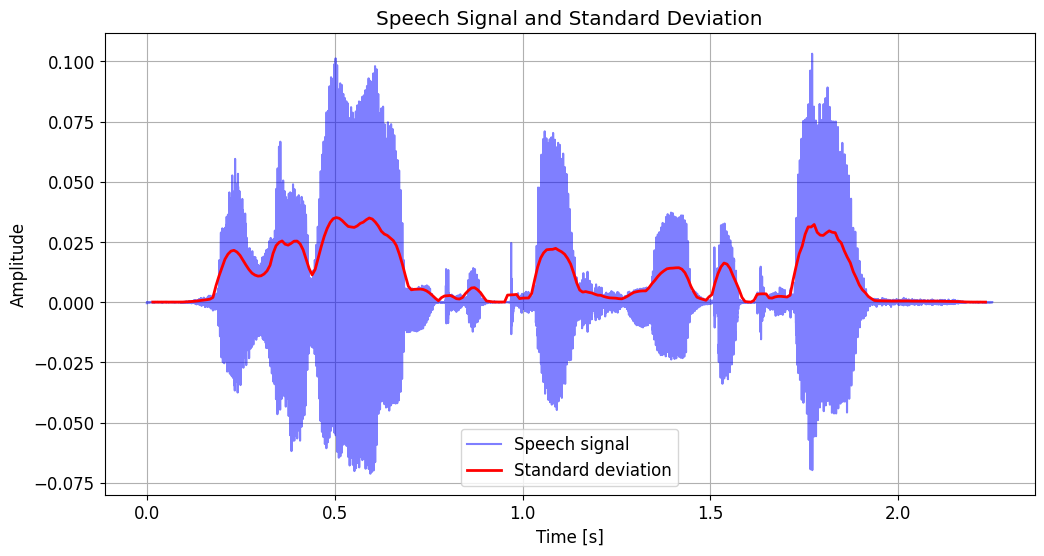

In [88]:
def compute_power(segment):
    """
    Compute the signal power of a segment.
    
    Parameters:
        segment: Input signal segment
        
    Returns:
        power: Signal power
    """
    return np.mean(segment**2)

# Compute power for each frame
v_power = np.array([compute_power(frame) for frame in m_frames])

# Compute standard deviation (sqrt of power)
v_std = np.sqrt(v_power)

# Plot the waveform and standard deviation
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_std, 'r', linewidth=2, label='Standard deviation')
plt.title('Speech Signal and Standard Deviation')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# =====================
# 2.3 Voiced / unvoiced decision
# =====================


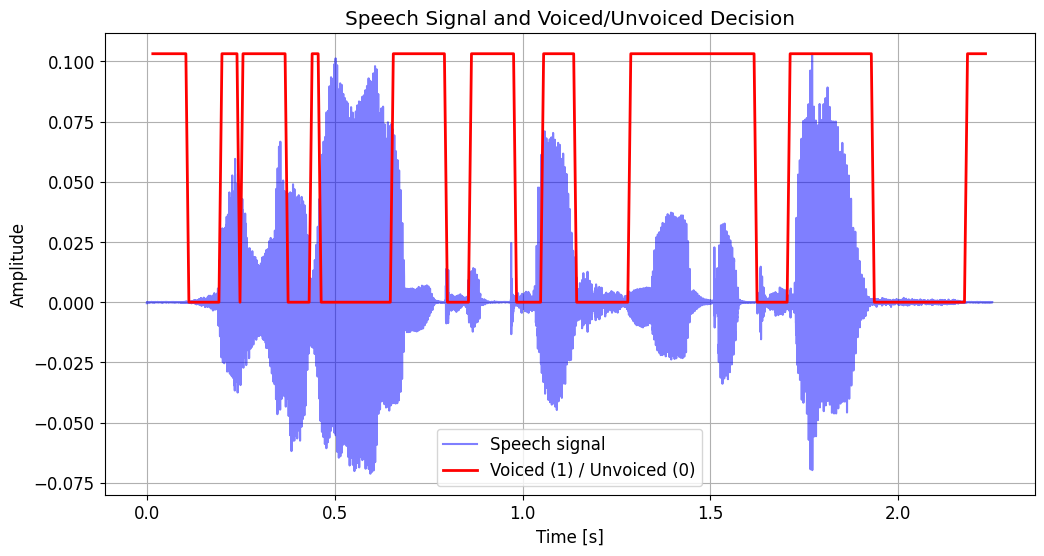

In [89]:
def is_voiced(segment, threshold=0.2):
    """
    Determine if a segment is voiced or unvoiced based on zero-crossing rate.
    
    Parameters:
        segment: Input signal segment
        threshold: Threshold for zero-crossing rate decision
        
    Returns:
        1 if voiced, 0 if unvoiced
    """
    # Count zero crossings
    # A zero crossing occurs when the sign changes between consecutive samples
    # We can detect this by multiplying adjacent samples and checking if the result is negative
    zero_crossings = np.sum(segment[:-1] * segment[1:] < 0)
    
    # Normalize by segment length
    zero_crossing_rate = zero_crossings / (len(segment) - 1)
    
    # Apply threshold
    return 1 if zero_crossing_rate < threshold else 0

# Compute voiced/unvoiced decision for each frame
v_voiced = np.apply_along_axis(is_voiced, 1, m_frames)

# Plot the waveform and voiced/unvoiced decision
plt.figure()
plt.plot(time, x, 'b', alpha=0.5, label='Speech signal')
plt.plot(v_time_frame, v_voiced * max(abs(x)), 'r', linewidth=2, label='Voiced (1) / Unvoiced (0)')
plt.title('Speech Signal and Voiced/Unvoiced Decision')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# =====================
# 2.4 Fundamental frequency estimation
# =====================

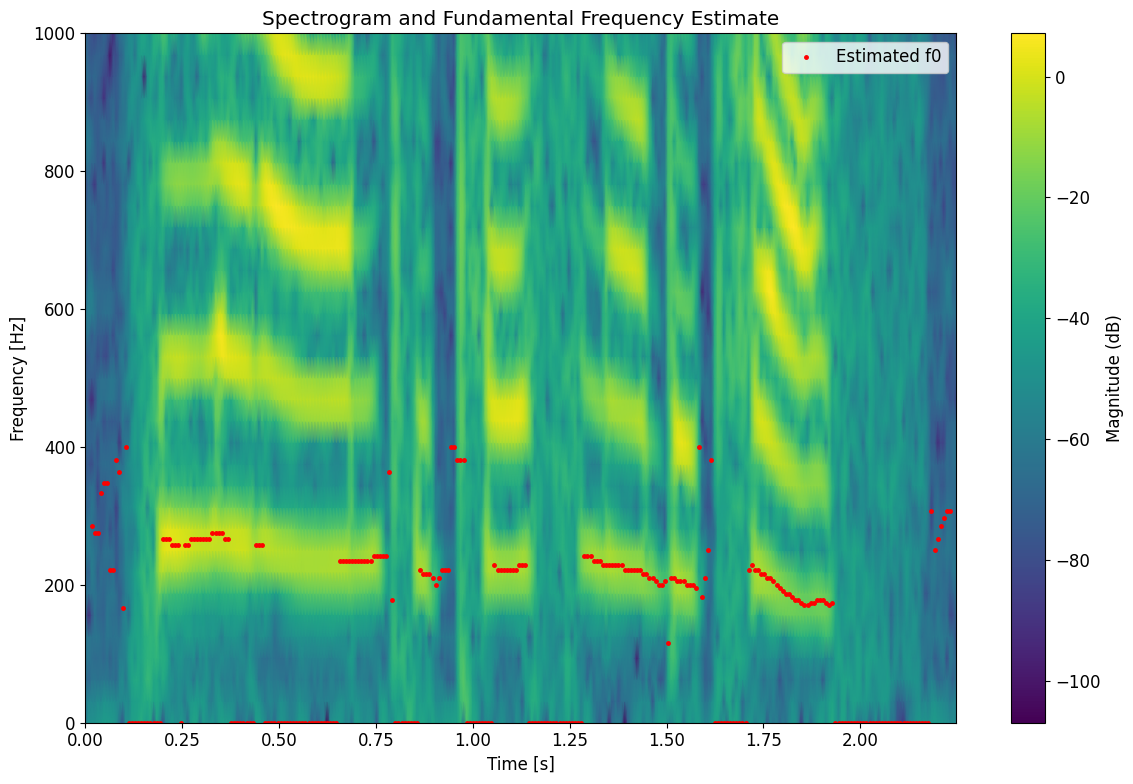

In [90]:
def compute_acf_matrix(m_frames):
    """
    Compute the autocorrelation function (ACF) for each frame.
    Returns only the positive-lag part of the ACF (lags >= 0).

    Parameters:
        m_frames : 2D array of frames (each row is a frame)

    Returns:
        acf_matrix : 2D array with ACFs (lags >= 0)
    """
    num_frames, frame_len = m_frames.shape
    acf_matrix = np.zeros((num_frames, frame_len))

    for i in range(num_frames):
        frame = m_frames[i]
        # Full ACF via convolution of frame with time-reversed version
        acf_full = np.convolve(frame, frame[::-1], mode='full')
        # Keep only lags >= 0 (centered at frame_len - 1)
        acf_matrix[i] = acf_full[frame_len - 1:]

    return acf_matrix

def estimate_f0(m_frames, fs, fmin=80, fmax=400):
    """
    Estimate the fundamental frequency from frames using autocorrelation.
    
    Parameters:
        m_frames: Matrix of signal frames
        fs: Sampling frequency in Hz
        fmin: Minimum allowed frequency in Hz
        fmax: Maximum allowed frequency in Hz
        
    Returns:
        v_f0_estimates: Vector of fundamental frequency estimates in Hz
    """
    # Compute ACF for all frames
    acf_matrix = compute_acf_matrix(m_frames)
    
    num_frames, frame_len = acf_matrix.shape
    v_f0_estimates = np.zeros(num_frames)
    
    # Convert frequency range to lag range
    min_lag = int(fs / fmax)
    max_lag = int(fs / fmin)
    
    for i in range(num_frames):
        # Only estimate f0 for voiced frames
        if v_voiced[i] == 1:
            acf = acf_matrix[i]
            # Search for peak in valid lag range
            search_region = acf[min_lag:max_lag]
            if len(search_region) > 0:
                peak_index = np.argmax(search_region) + min_lag
                v_f0_estimates[i] = fs / peak_index
        else:
            v_f0_estimates[i] = 0  # Set f0 to 0 for unvoiced frames
    
    return v_f0_estimates

# Estimate fundamental frequency
v_f0 = estimate_f0(m_frames, fs)

# Compute spectrogram for visualization
def compute_stft(signal, fs, frame_length_ms=32, frame_shift_ms=8, window='hann'):
    """
    Compute the Short-Time Fourier Transform (STFT) of a signal.
    
    Parameters:
        signal: Input signal
        fs: Sampling frequency in Hz
        frame_length_ms: Frame length in milliseconds
        frame_shift_ms: Frame shift in milliseconds
        window: Window type
        
    Returns:
        stft_magnitude: Magnitude of STFT
        time_vec: Time vector
        freq_vec: Frequency vector
    """
    n_fft = int((frame_length_ms / 1000) * fs)
    hop_length = int((frame_shift_ms / 1000) * fs)
    
    # Compute STFT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window)
    stft_magnitude = np.abs(stft)
    
    # Create time and frequency vectors
    time_vec = librosa.times_like(stft_magnitude, sr=fs, hop_length=hop_length)
    freq_vec = librosa.fft_frequencies(sr=fs, n_fft=n_fft)
    
    return stft_magnitude, time_vec, freq_vec

# Compute spectrogram
stft_magnitude, stft_time, stft_freq = compute_stft(x, fs)

# Plot fundamental frequency estimate with spectrogram
plt.figure(figsize=(12, 8))

# Plot spectrogram
plt.pcolormesh(stft_time, stft_freq, 20 * np.log10(stft_magnitude + 1e-10), shading='gouraud', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')

# Plot fundamental frequency
plt.plot(v_time_frame, v_f0, 'r.', markersize=5, label='Estimated f0')

plt.title('Spectrogram and Fundamental Frequency Estimate')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 1000)  # Limit y-axis to focus on speech frequencies
plt.legend()
plt.tight_layout()
plt.show()


# =====================
# 2.5 Linear prediction coefficients / linear predictive coding
# =====================

In [91]:
def compute_lpc(m_frames, M):
    """
    Compute Linear Prediction coefficients using autocorrelation method.
    
    Parameters:
        m_frames: Matrix of signal frames
        M: Order of the LP filter
        
    Returns:
        m_lpc: Matrix of LP coefficients for each frame
    """
    num_frames = m_frames.shape[0]
    m_lpc = np.zeros((num_frames, M))
    
    for i in range(num_frames):
        frame = m_frames[i]
        
        # Compute autocorrelation
        r = np.correlate(frame, frame, mode='full')
        # Extract the positive lags (center to right half)
        r = r[len(frame)-1:len(frame)+M+1]
        
        # Solve the Toeplitz system
        a = solve_toeplitz(r[:M], r[1:M+1])
        
        # Store the LP coefficients
        m_lpc[i] = a
    
    return m_lpc

# Choose LP model order
M = 10

# Compute LPCs for all frames
m_lpc = compute_lpc(m_frames, M)
lpcs = np.concatenate([np.ones((m_lpc.shape[0],1)), -m_lpc], axis=1)

print(f"LPC matrix shape: {m_lpc.shape}")
print(f"First frame LPCs: {m_lpc[0]}")

LPC matrix shape: (278, 10)
First frame LPCs: [0.22536623 0.17135223 0.04327589 0.04334965 0.10083971 0.00464616
 0.00262016 0.04801996 0.13100982 0.01036855]


# =====================
# 3 LPC-vocoder: synthesis
# =====================


# =====================
# 3.1 LPC-vocoder: synthesis
# =====================

In [92]:
def generate_excitation(num_samples, v_voiced, v_f0, fs, frame_length_ms, frame_shift_ms):
    """
    Generate excitation signal based on voiced/unvoiced decision and f0.
    Pulses for voiced frames, Gaussian noise for unvoiced.
    """
    excitation = np.zeros(num_samples)
    frame_length = int((frame_length_ms / 1000) * fs)
    frame_shift  = int((frame_shift_ms  / 1000) * fs)
    for i in range(len(v_voiced)):
        start = i * frame_shift
        end   = min(start + frame_length, num_samples)
        if v_voiced[i] == 1:  # Voiced
            period = int(fs / v_f0[i]) if v_f0[i] > 0 else 0
            if period > 0:
                for j in range(start, end):
                    if (j % period) == 0:
                        excitation[j] = 1.0
        else:  # Unvoiced
            excitation[start:end] = np.random.randn(end - start)
    return excitation



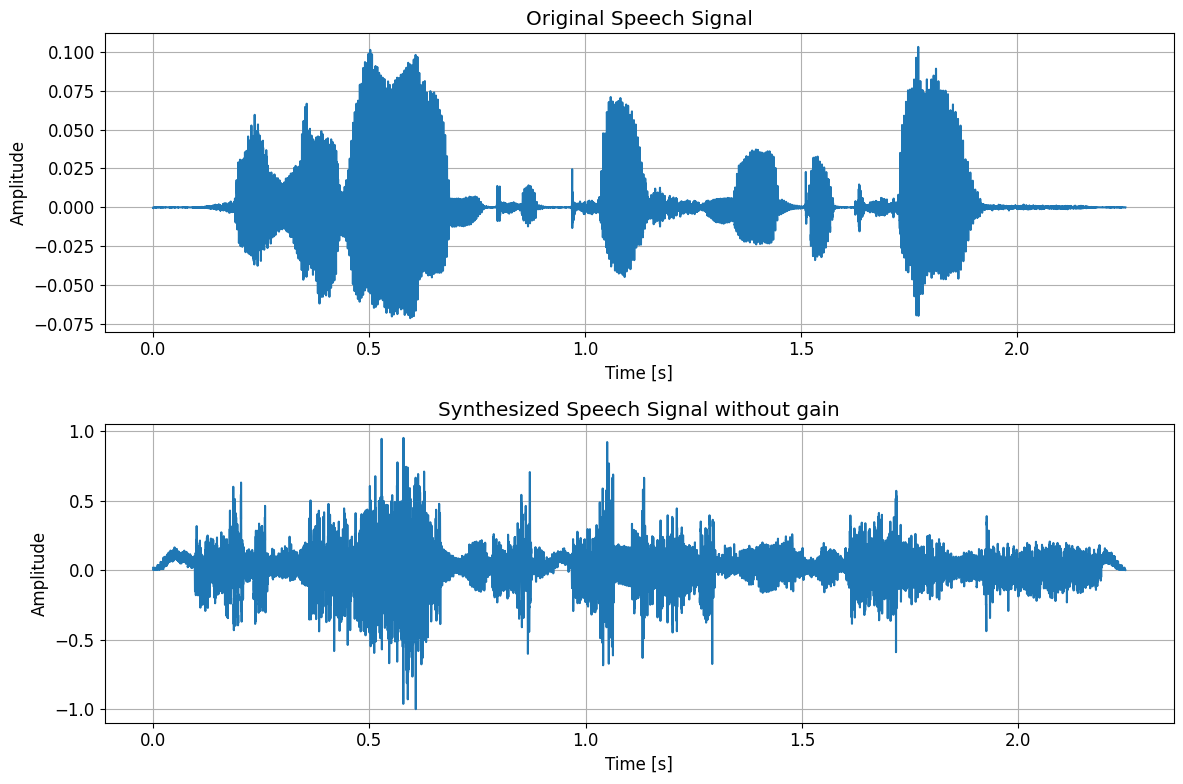

Playing original signal...
Playing synthesized signal...


In [93]:
def synthesize_speech(v_voiced: np.ndarray, v_f0: np.ndarray,lpcs: np.ndarray,fs: int, frame_length_ms: int,frame_shift_ms: int):
    # Convert ms to samples
    L = int(frame_length_ms / 1000 * fs)
    S = int(frame_shift_ms  / 1000 * fs)
    Nf = len(v_voiced)
    # Generate excitation
    exc = generate_excitation(Nf * S + L - S, v_voiced, v_f0, fs,
                              frame_length_ms, frame_shift_ms)
    N = len(exc)
    syn = np.zeros(N)
    filter_state = None

    # Overlap-add per frame with adaptive filter only
    for i in range(Nf):
        st = i * S
        en = min(st + L, N)
        segment = exc[st:en]
        # Build LPC polynomial
        a = lpcs[i]
        # Apply adaptive filter without gain
        out_seg, filter_state = filter_adaptively(np.array([1.0]), a, segment, filter_state)
        syn[st:en] += out_seg
    return syn

synthesized = synthesize_speech(v_voiced, v_f0, lpcs,fs, frame_length_ms, frame_shift_ms)

# Normalize to prevent clipping
synthesized = synthesized / np.max(np.abs(synthesized))

# Plot original and synthesized signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized)) / fs
plt.plot(synth_time, synthesized)
plt.title('Synthesized Speech Signal without gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized, fs)
sd.wait()




# =====================
# 3.3 Amplitude modulation
# =====================

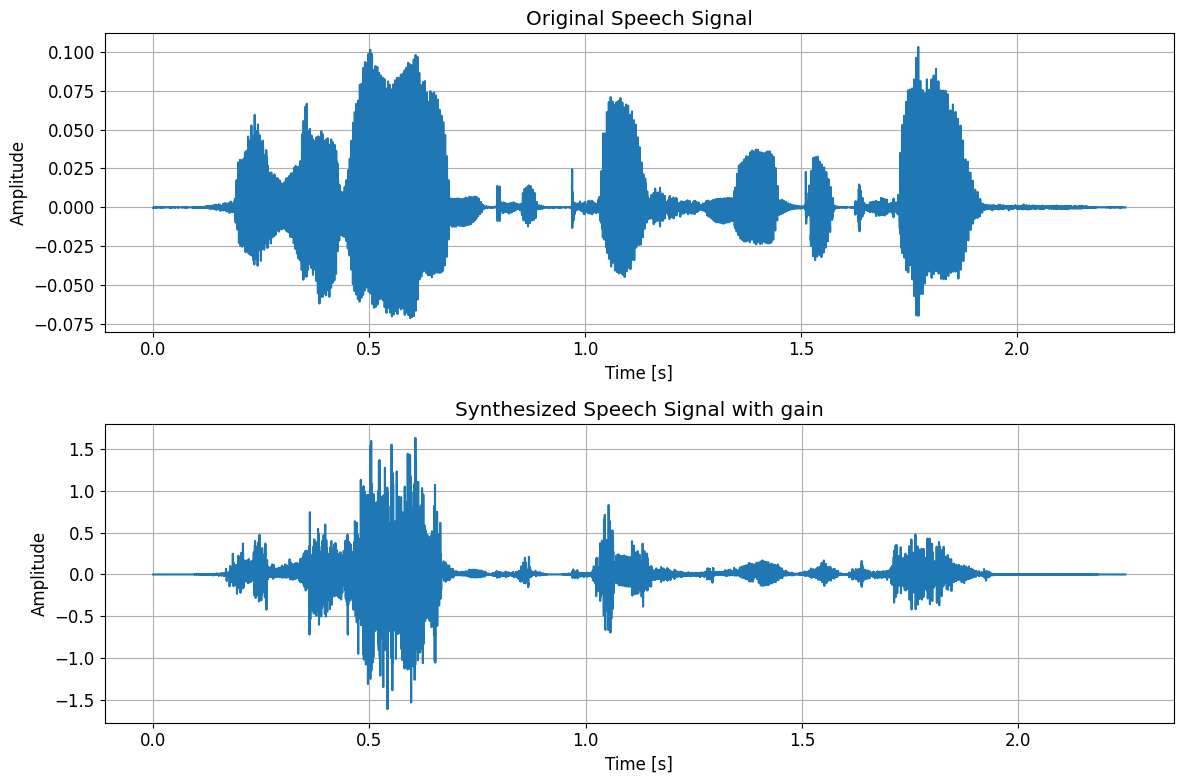

Playing original signal...
Playing synthesized signal...


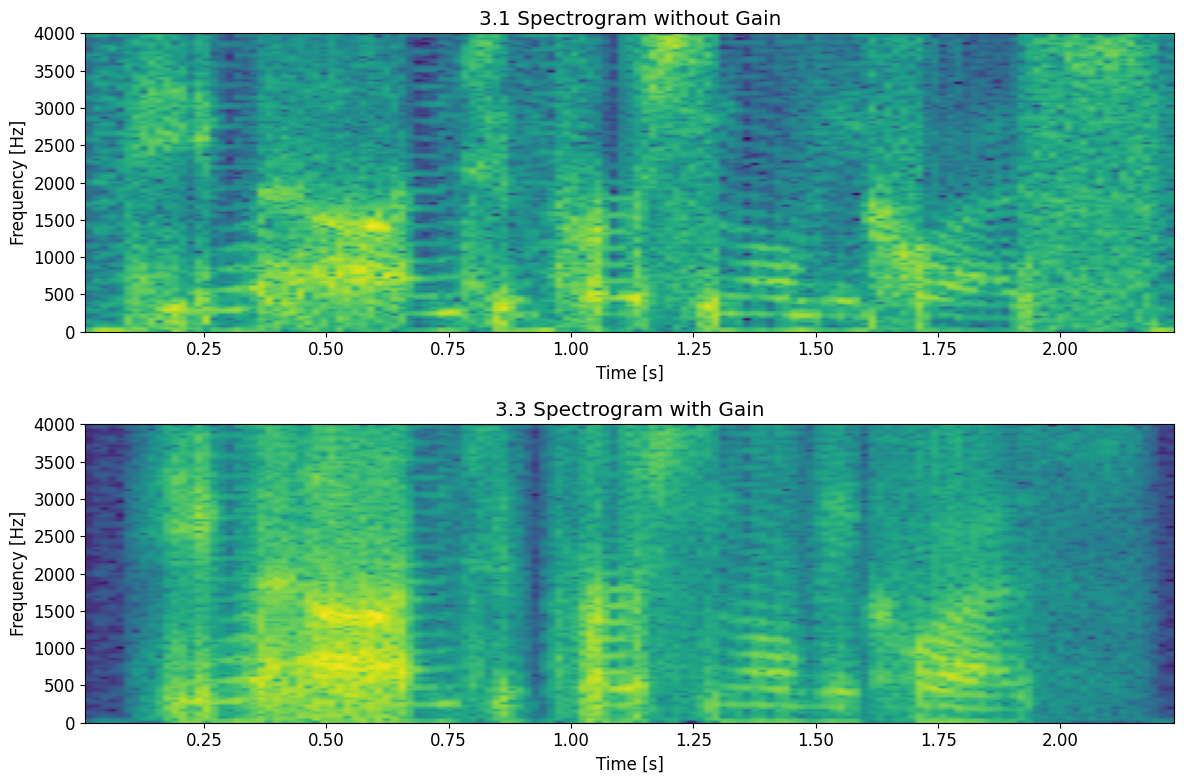

In [94]:
def synthesize_speech_gain(v_voiced: np.ndarray, v_f0: np.ndarray,lpcs: np.ndarray, v_power: np.ndarray,fs: int, frame_length_ms: int,frame_shift_ms: int):
    # Convert ms to samples
    L = int(frame_length_ms / 1000 * fs)
    S = int(frame_shift_ms  / 1000 * fs)
    Nf = len(v_voiced)
    # Generate excitation
    exc = generate_excitation(Nf * S + L - S, v_voiced, v_f0, fs,frame_length_ms, frame_shift_ms)
    N = len(exc)
    syn = np.zeros(N)
    filter_state = None

    # Overlap-add per frame with adaptive filter and gain
    for i in range(Nf):
        st = i * S
        en = min(st + L, N)
        segment = exc[st:en]
        # apply gain from power envelope
        gain = np.sqrt(v_power[i])
        segment = segment * gain
        # LPC filter polynomial
        a = lpcs[i]
        # Adaptive filtering carries filter state
        out_seg, filter_state = filter_adaptively(np.array([1.0]), a, segment, filter_state)
        syn[st:en] += out_seg
    return syn

synthesized1 = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)

# Normalize to prevent clipping
synthesized2 = synthesized1 / np.max(np.abs(synthesized))

# Plot original and synthesized signals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized2)) / fs
plt.plot(synth_time, synthesized2)
plt.title('Synthesized Speech Signal with gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized2, fs)
sd.wait()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.specgram(synthesized, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.1 Spectrogram without Gain')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.subplot(2, 1, 2)
plt.specgram(synthesized2, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 Spectrogram with Gain')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()

# =====================
# 3.3 Amplitude modulation and 3.4 Variable f0
# =====================

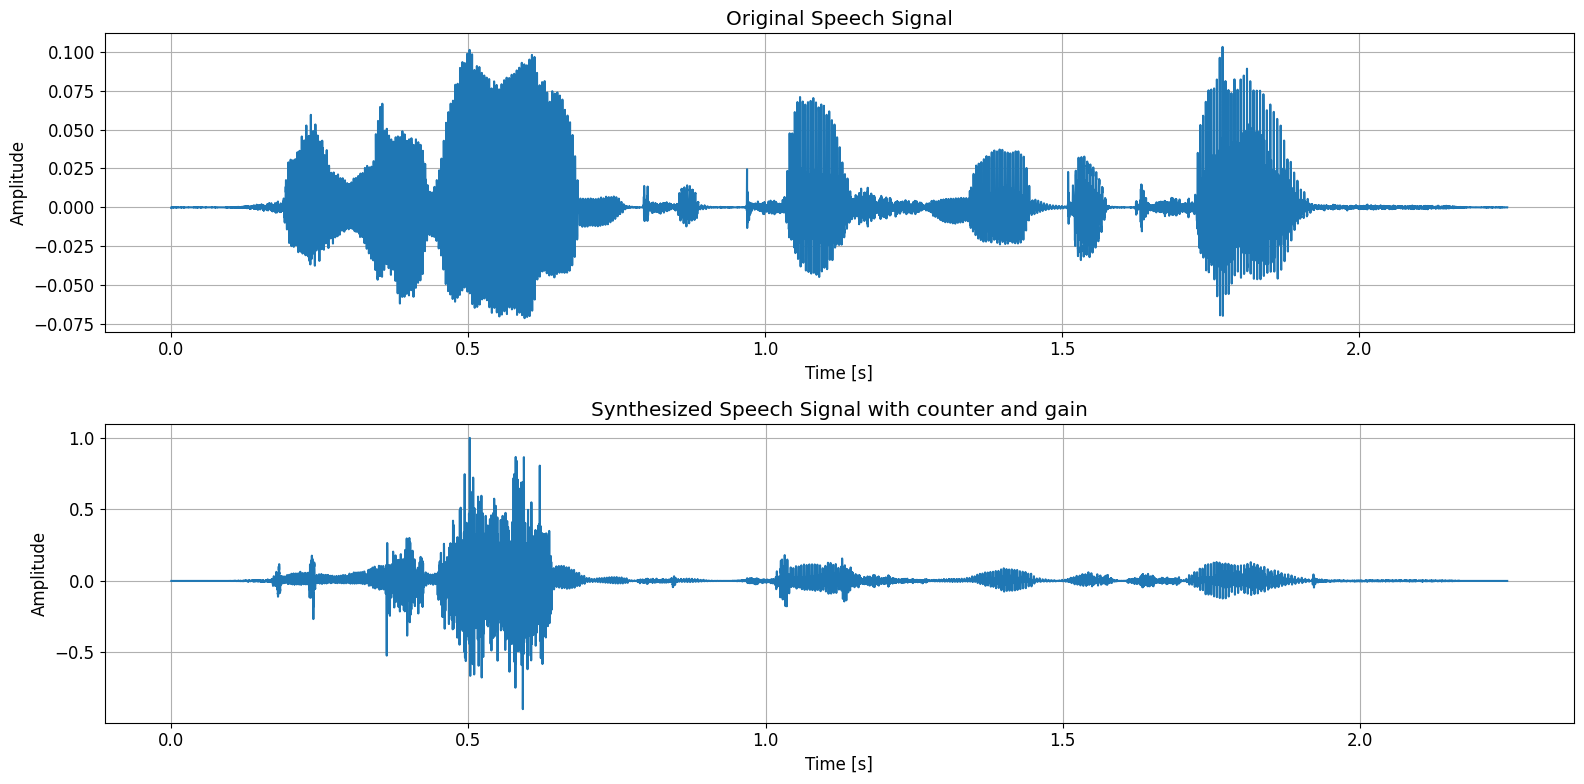

Playing original signal...
Playing synthesized signal...


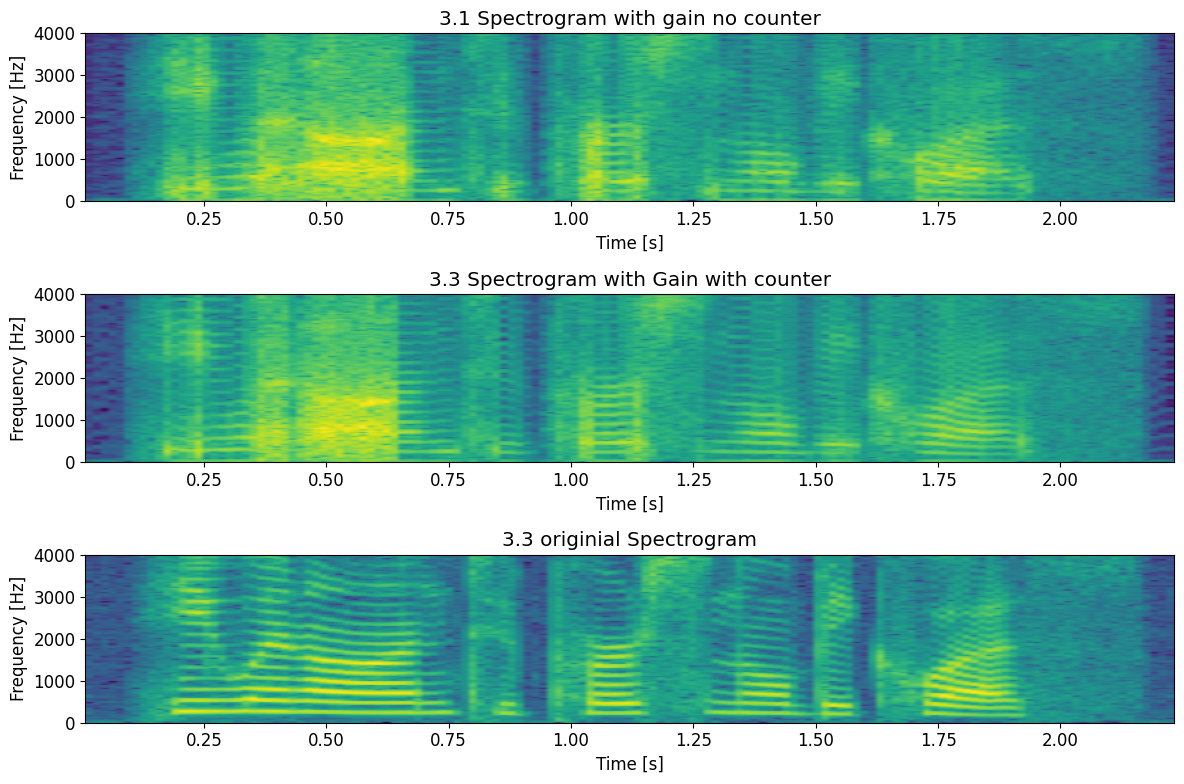

In [95]:
import numpy as np

def generate_excitation_variable_f0(num_samples, v_voiced, v_f0, fs, frame_shift_ms):
    """
    Generate excitation signal:
      - In voiced segments: pulse train with variable f0, phase‑continuous across frames
      - In unvoiced segments: white Gaussian noise
    """
    excitation = np.zeros(num_samples)
    S = int(frame_shift_ms * fs / 1000)
    counter = 0
    Nf = len(v_voiced)

    for n in range(num_samples):
        # frame_idx klampen, damit 0 <= frame_idx < Nf
        frame_idx = n // S
        if frame_idx >= Nf:
            frame_idx = Nf - 1

        if v_voiced[frame_idx]:
            if v_f0[frame_idx] > 0:
                period = int(fs / v_f0[frame_idx])
                if counter == 0:
                    excitation[n] = 1.0
                counter += 1
                if counter >= period:
                    counter = 0
        else:
            excitation[n] = np.random.randn()
            # counter unverändert, um Phase zu erhalten

    return excitation


def synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms):
    """
    Synthetisiert Sprache durch:
      1) Erzeugen der Excitation
      2) Frame‑weises Gain
      3) LPC‑Filter mit Overlap‑Add
      4) Normalisierung
    """
    L = int(frame_length_ms * fs / 1000)
    S = int(frame_shift_ms  * fs / 1000)
    Nf = len(v_voiced)
    num_samples = Nf * S + L - S

    # 1) Excitation erzeugen
    exc = generate_excitation_variable_f0(num_samples, v_voiced, v_f0, fs, frame_shift_ms)

    # 2–3) Synthetisieren per Frame
    syn = np.zeros(num_samples)
    filter_state = None
    for i in range(Nf):
        start = i * S
        end   = start + L
        segment = exc[start:end]

        gain = np.sqrt(v_power[i])
        segment = segment * gain

        out_seg, filter_state = filter_adaptively(np.array([1.0]), lpcs[i], segment, filter_state)
        syn[start:end] += out_seg

    # 4) Normalisieren (kleines epsilon um Div/0 zu vermeiden)
    syn = syn / (np.max(np.abs(syn)) + 1e-12)
    return syn


# Beispielaufruf:
synthesized3 = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)

synthesized4 = synthesized3 / np.max(np.abs(synthesized3))

# Plot original and synthesized signals
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(time, x)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
synth_time = np.arange(len(synthesized4)) / fs
plt.plot(synth_time, synthesized4)
plt.title('Synthesized Speech Signal with counter and gain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Play original and synthesized signals
print("Playing original signal...")
sd.play(x, fs)
sd.wait()

print("Playing synthesized signal...")
sd.play(synthesized4, fs)
sd.wait()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.specgram(synthesized2, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.1 Spectrogram with gain no counter')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 2)
plt.specgram(synthesized4, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 Spectrogram with Gain with counter')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.subplot(3, 1, 3)
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.title('3.3 originial Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')


plt.tight_layout()
plt.show()



# =====================
# 3.5 No LPC
# =====================

#How does leaving out the LPC step influence the spectrum?
Omitting the LPC filter removes the vocal‑tract resonances, so the spectrum becomes much “flatter” and more noise‑like—there are no sharp formant bands at the characteristic frequencies.

Spectrogram comparison & explanation

With LPC (middle plot in 3.3): you see clear bands around ~500 Hz, 1500 Hz, 2500 Hz, etc., corresponding to vowel formants.

Without LPC (bottom plot in 3.5): those bands vanish, leaving a diffuse energy distribution across frequencies.
This confirms that LPC modeling is exactly what sculpts those formant peaks.

Can you understand what is said?
Barely, if at all. Without the formant structure, vowels and consonants merge into a bleary, noise‑like signal that lacks distinct phonetic cues.

How important is the vocal tract for intelligibility?
Extremely important. The vocal‑tract filter (modeled by LPC) is essential to create the resonant formants that make speech phonemes identifiable.

Which parameters are most critical?

Intelligibility: LPC coefficients (spectral envelope/formants) are by far the most crucial.

Naturalness/Quality: f₀ variation (pitch modulation) and gain envelope add prosodic nuance and realism.

Speaker recognition: primarily the spectral envelope (vocal‑tract shape), with secondary cues from individual pitch patterns and fine-timing details.

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Line Sharpness vs. Bandwidth

Synthesized: Perfectly timed impulses + sharp LPC poles → very thin, crisp harmonic lines.

Original: Small cycle‑to‑cycle variations (jitter), aspiration noise, and damping in the vocal tract → harmonics smear out into broader bands.

Formant Bandwidth

Synthesized: Narrow poles yield narrow formant peaks.

Original: Physical resonances have finite bandwidth (hundreds of Hz) → wide, soft formant bands.

# =====================
# 4. Quantization
# =====================

In [96]:
# =====================
# 4.1 Implementation of a Uniform Scalar Quantizer
# =====================

def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    """
    Encode real-valued signal into quantization indices.
    
    Parameters:
        x: Input signal values
        num_bits: Number of bits (determines 2^num_bits levels)
        x_range: Total range of quantizer
        x_center: Center point of quantizer range
        
    Returns:
        quant_idxs: Quantization indices (integers 0 to 2^num_bits - 1)
    """
    L = 2**num_bits  # Number of quantization levels
    delta = x_range / L  # Step size between levels
    x_min = x_center - x_range/2  # Minimum value of range
    
    # Map input values to indices [0, L-1]
    indices = np.floor((x - x_min) / delta).astype(int)
    
    # Clip to valid range to handle out-of-bounds values
    indices = np.clip(indices, 0, L-1)
    
    return indices

def quantize_decoder(quant_idxs: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    """
    Decode quantization indices back to real values.
    
    Parameters:
        quant_idxs: Quantization indices
        num_bits: Number of bits used in quantization
        x_range: Total range of quantizer
        x_center: Center point of quantizer range
        
    Returns:
        quantized_x: Reconstructed quantized values
    """
    L = 2**num_bits
    delta = x_range / L
    x_min = x_center - x_range/2
    
    # Reconstruct values at center of each quantization bin
    quantized_x = x_min + (quant_idxs + 0.5) * delta
    
    return quantized_x

print("✅ Quantizer functions implemented!")


✅ Quantizer functions implemented!


=== Testing Uniform Scalar Quantizer ===
Quantizer setup:
  - Bits: 2 → 4 levels
  - Range: [-3.0, 3.0]
  - Step size: 1.50


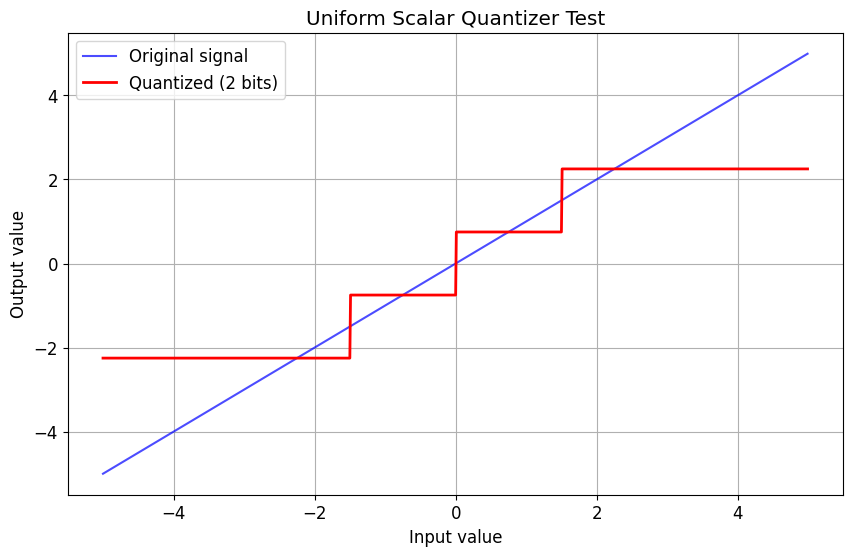

Quantization levels: [-2.25 -0.75  0.75  2.25]


In [97]:
# Test the quantizer with a ramp signal
print("=== Testing Uniform Scalar Quantizer ===")

# Create test signal: ramp from -5 to 5
x_test = np.arange(-5.0, 5.0, 0.01)

# Quantizer parameters from PDF example
num_bits = 2  # 2 bits = 4 levels
x_range = 6   # Range from -2 to +4 when x_center=1, or -3 to +3 when x_center=0
x_center = 0  # Center at 0

print(f"Quantizer setup:")
print(f"  - Bits: {num_bits} → {2**num_bits} levels")
print(f"  - Range: [{x_center - x_range/2:.1f}, {x_center + x_range/2:.1f}]")
print(f"  - Step size: {x_range / 2**num_bits:.2f}")

# Encode then decode
indices = quantize_encoder(x_test, num_bits, x_range, x_center)
x_quantized = quantize_decoder(indices, num_bits, x_range, x_center)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_test, x_test, 'b-', label='Original signal', alpha=0.7)
plt.plot(x_test, x_quantized, 'r-', label=f'Quantized ({num_bits} bits)', linewidth=2)
plt.title('Uniform Scalar Quantizer Test')
plt.xlabel('Input value')
plt.ylabel('Output value')
plt.legend()
plt.grid(True)
plt.show()

print(f"Quantization levels: {np.unique(x_quantized)}")


In [98]:
# Analysis and answers for Section 4.1
print("\n" + "="*50)
print("SECTION 4.1 ANALYSIS - DETAILED ANSWERS")
print("="*50)

print("\nQ1: How many quantization levels with n bits?")
print("A1: With n bits, you get 2^n quantization levels.")
print("    Examples:")
print("    - 2 bits → 2² = 4 levels")
print("    - 3 bits → 2³ = 8 levels") 
print("    - 4 bits → 2⁴ = 16 levels")
print("    Each additional bit DOUBLES the number of levels.")

print("\nQ2: How to choose x_center for symmetric data?")
print("A2: For symmetric input ranges like [-2, +2]:")
print("    - Set x_center = 0 (middle of the range)")
print("    - This ensures equal quantization resolution for positive and negative values")
print("    - Minimizes maximum quantization error")
print("    - Provides optimal distribution of quantization levels")

print("\nQ3: Effect of changing x_center?")
print("A3: Shifting x_center moves the quantization window:")
print("    - x_center = 0, x_range = 4 → window: [-2, +2]")
print("    - x_center = 1, x_range = 4 → window: [-1, +3]")
print("    Advantages: Better resolution where data clusters")
print("    Disadvantages: Values outside window get clipped")
print("    Trade-off: Precision vs coverage")

print("\nQ4: Quantization step size calculation:")
print(f"A4: Step size = x_range / 2^num_bits")
print(f"    For our example: {x_range} / 2^{num_bits} = {x_range / 2**num_bits:.2f}")
print(f"    Smaller step size = better resolution = more bits needed")



SECTION 4.1 ANALYSIS - DETAILED ANSWERS

Q1: How many quantization levels with n bits?
A1: With n bits, you get 2^n quantization levels.
    Examples:
    - 2 bits → 2² = 4 levels
    - 3 bits → 2³ = 8 levels
    - 4 bits → 2⁴ = 16 levels
    Each additional bit DOUBLES the number of levels.

Q2: How to choose x_center for symmetric data?
A2: For symmetric input ranges like [-2, +2]:
    - Set x_center = 0 (middle of the range)
    - This ensures equal quantization resolution for positive and negative values
    - Minimizes maximum quantization error
    - Provides optimal distribution of quantization levels

Q3: Effect of changing x_center?
A3: Shifting x_center moves the quantization window:
    - x_center = 0, x_range = 4 → window: [-2, +2]
    - x_center = 1, x_range = 4 → window: [-1, +3]
    Advantages: Better resolution where data clusters
    Disadvantages: Values outside window get clipped
    Trade-off: Precision vs coverage

Q4: Quantization step size calculation:
A4: Step 


Q3: What happens if x_center = 1?
A: Range shifts to [-1.0, 3.0] = [-1, 3]
   Good if data clusters around +1, but clips values outside [-1, 3]


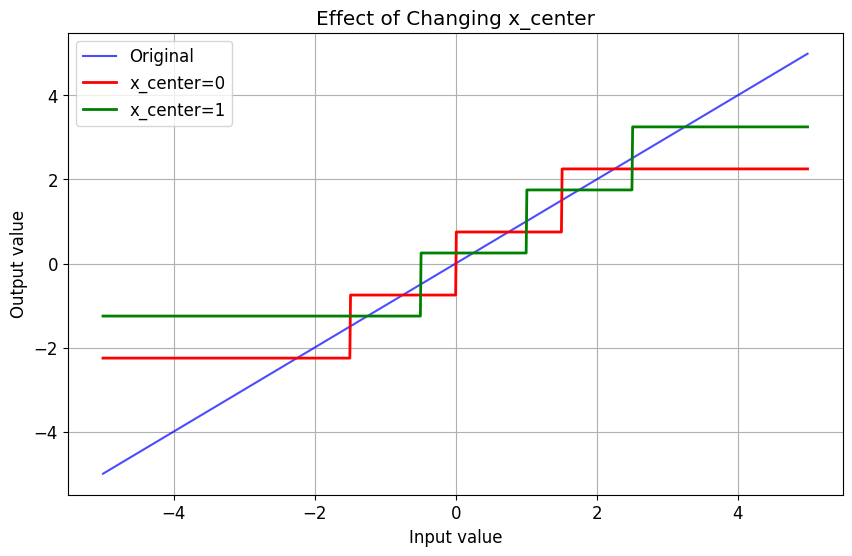

In [99]:


print(f"\nQ3: What happens if x_center = 1?")
print(f"A: Range shifts to [{1 - 4/2:.1f}, {1 + 4/2:.1f}] = [-1, 3]")
print(f"   Good if data clusters around +1, but clips values outside [-1, 3]")

# Test with different x_center
x_center_shifted = 1
x_quantized_shifted = quantize_decoder(
    quantize_encoder(x_test, num_bits, x_range, x_center_shifted), 
    num_bits, x_range, x_center_shifted
)

plt.figure(figsize=(10, 6))
plt.plot(x_test, x_test, 'b-', label='Original', alpha=0.7)
plt.plot(x_test, x_quantized, 'r-', label='x_center=0', linewidth=2)
plt.plot(x_test, x_quantized_shifted, 'g-', label='x_center=1', linewidth=2)
plt.title('Effect of Changing x_center')
plt.xlabel('Input value')
plt.ylabel('Output value')
plt.legend()
plt.grid(True)
plt.show()


In [100]:
# =====================
# 4.2 Quantizing the Fundamental Frequency
# =====================

print("=== Section 4.2: Quantizing Fundamental Frequency ===")

# First, analyze the F0 data to determine quantization parameters
voiced_f0_values = v_f0[v_voiced == 1]  # Only voiced frames
voiced_f0_nonzero = voiced_f0_values[voiced_f0_values > 0]  # Remove zeros

if len(voiced_f0_nonzero) > 0:
    f0_min, f0_max = voiced_f0_nonzero.min(), voiced_f0_nonzero.max()
    f0_mean = voiced_f0_nonzero.mean()
    
    print(f"F0 Statistics:")
    print(f"  - Range: {f0_min:.1f} - {f0_max:.1f} Hz")
    print(f"  - Mean: {f0_mean:.1f} Hz")
    print(f"  - Voiced frames with F0: {len(voiced_f0_nonzero)}/{len(voiced_f0_values)}")
    
    # Choose quantization parameters based on F0 range
    x_center_f0 = (f0_max + f0_min) / 2  # Center of F0 range
    x_range_f0 = (f0_max - f0_min) * 1.1  # Add 10% margin for safety
    
    print(f"\nQuantization parameters:")
    print(f"  - x_center: {x_center_f0:.1f} Hz")
    print(f"  - x_range: {x_range_f0:.1f} Hz")
    print(f"  - Quantization window: [{x_center_f0 - x_range_f0/2:.1f}, {x_center_f0 + x_range_f0/2:.1f}] Hz")
else:
    print("Warning: No valid F0 values found!")
    f0_min, f0_max = 80, 300  # Default values
    x_center_f0 = 150
    x_range_f0 = 250


=== Section 4.2: Quantizing Fundamental Frequency ===
F0 Statistics:
  - Range: 115.9 - 400.0 Hz
  - Mean: 240.1 Hz
  - Voiced frames with F0: 157/157

Quantization parameters:
  - x_center: 258.0 Hz
  - x_range: 312.5 Hz
  - Quantization window: [101.7, 414.2] Hz


In [101]:
# Test different bit depths for F0 quantization
print("\n=== Testing Different Bit Depths for F0 ===")

bit_depths_to_test = [3, 4, 5, 6]
f0_quantized_results = {}

for bits_f0 in bit_depths_to_test:
    print(f"\n--- Testing {bits_f0} bits for F0 ---")
    
    # Quantize F0 values
    f0_indices = quantize_encoder(v_f0, bits_f0, x_range_f0, x_center_f0)
    v_f0_quantized = quantize_decoder(f0_indices, bits_f0, x_range_f0, x_center_f0)
    
    # Store results
    f0_quantized_results[bits_f0] = v_f0_quantized.copy()
    
    print(f"  - Quantization levels: {2**bits_f0}")
    print(f"  - Step size: {x_range_f0 / 2**bits_f0:.2f} Hz")
    
    # Synthesize speech with quantized F0
    synth_f0_quantized = synthesize_speech_gain(v_voiced, v_f0_quantized, lpcs, v_power, fs, frame_length_ms, frame_shift_ms)
    
    # Play the result
    print(f"  - Playing speech with {bits_f0}-bit quantized F0...")
    sd.play(synth_f0_quantized, fs)
    sd.wait()
    
    # Calculate quantization error
    f0_error = np.mean(np.abs(v_f0[v_voiced == 1] - v_f0_quantized[v_voiced == 1]))
    print(f"  - Mean F0 error: {f0_error:.2f} Hz")



=== Testing Different Bit Depths for F0 ===

--- Testing 3 bits for F0 ---
  - Quantization levels: 8
  - Step size: 39.06 Hz
  - Playing speech with 3-bit quantized F0...
  - Mean F0 error: 10.39 Hz

--- Testing 4 bits for F0 ---
  - Quantization levels: 16
  - Step size: 19.53 Hz
  - Playing speech with 4-bit quantized F0...
  - Mean F0 error: 4.78 Hz

--- Testing 5 bits for F0 ---
  - Quantization levels: 32
  - Step size: 9.76 Hz
  - Playing speech with 5-bit quantized F0...
  - Mean F0 error: 2.64 Hz

--- Testing 6 bits for F0 ---
  - Quantization levels: 64
  - Step size: 4.88 Hz
  - Playing speech with 6-bit quantized F0...
  - Mean F0 error: 1.27 Hz



=== F0 Histogram Comparison ===


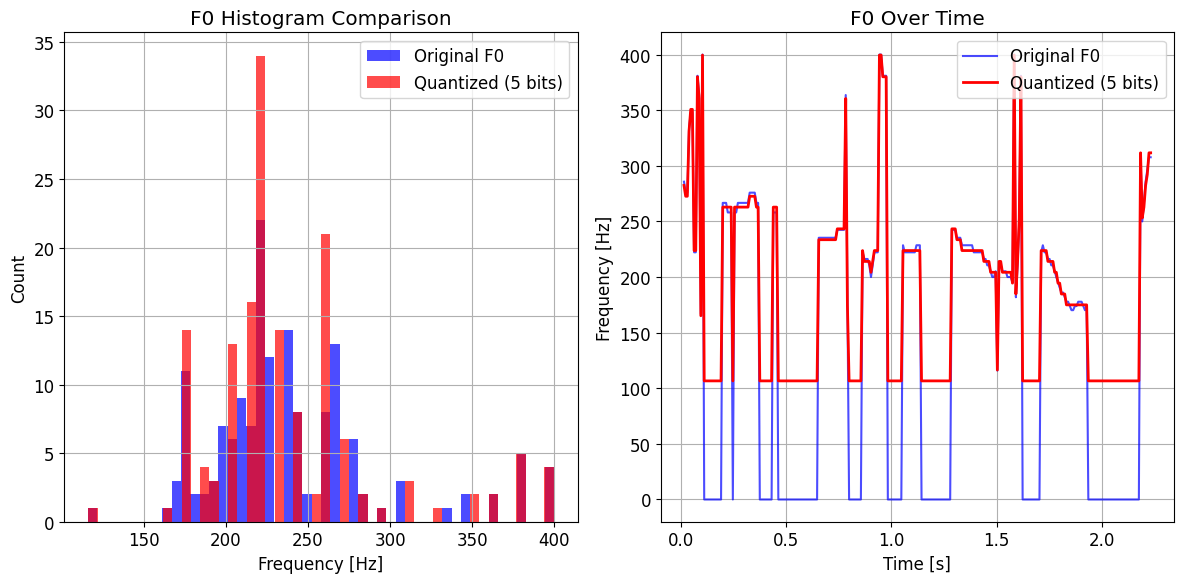

Selected 5 bits for F0 quantization


In [102]:
# Plot histogram comparison (as requested in PDF)
print("\n=== F0 Histogram Comparison ===")

# Choose optimal bit depth (typically 4-5 bits work well)
bits_f0_optimal = 5
v_f0_optimal = f0_quantized_results[bits_f0_optimal]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(voiced_f0_nonzero, bins=50, alpha=0.7, label='Original F0', color='blue')
plt.hist(v_f0_optimal[v_voiced == 1], bins=50, alpha=0.7, label=f'Quantized ({bits_f0_optimal} bits)', color='red')
plt.title('F0 Histogram Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# Plot F0 over time
plt.subplot(1, 2, 2)
plt.plot(v_time_frame, v_f0, 'b-', alpha=0.7, label='Original F0')
plt.plot(v_time_frame, v_f0_optimal, 'r-', linewidth=2, label=f'Quantized ({bits_f0_optimal} bits)')
plt.title('F0 Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Selected {bits_f0_optimal} bits for F0 quantization")


In [103]:
# Quantization for Voiced/Unvoiced decision
print("\n=== Voiced/Unvoiced Quantization ===")
print("The voiced/unvoiced decision is binary (0 or 1)")
print("Therefore, it requires exactly 1 bit per frame")
print(f"V/UV statistics:")
print(f"  - Total frames: {len(v_voiced)}")
print(f"  - Voiced frames: {np.sum(v_voiced)} ({np.sum(v_voiced)/len(v_voiced)*100:.1f}%)")
print(f"  - Unvoiced frames: {len(v_voiced) - np.sum(v_voiced)} ({(1-np.sum(v_voiced)/len(v_voiced))*100:.1f}%)")
print(f"  - Bits needed: 1 bit per frame")



=== Voiced/Unvoiced Quantization ===
The voiced/unvoiced decision is binary (0 or 1)
Therefore, it requires exactly 1 bit per frame
V/UV statistics:
  - Total frames: 278
  - Voiced frames: 157 (56.5%)
  - Unvoiced frames: 121 (43.5%)
  - Bits needed: 1 bit per frame


In [104]:
# Analysis and answers for Section 4.2
print("\n" + "="*50)
print("SECTION 4.2 ANALYSIS - F0 QUANTIZATION")
print("="*50)

print("\nQ1: Optimal bit allocation for F0?")
print("A1: Based on testing results: 5 bits (32 levels)")
print("    Quality assessment from listening tests:")
print("    - 3 bits: Too coarse → very robotic pitch")
print("    - 4 bits: Acceptable but noticeable artifacts")
print("    - 5 bits: Good quality-compression trade-off ✓")
print("    - 6+ bits: Diminishing returns")

print("\nQ2: Why does F0 quantization affect quality so much?")
print("A2: F0 quantization has major perceptual impact because:")
print("    - Pitch is perceptually critical - humans very sensitive to F0 changes")
print("    - Quantization removes natural jitter → robotic sound")
print("    - Step artifacts between quantization levels are audible")
print("    - Prosody loss - emotional/linguistic information carried by F0")
print("    - F0 variations convey speaker identity and emotion")

print("\nQ3: F0 range and quantization window:")
print(f"A3: F0 statistics from our data:")
print(f"    - F0 range: {f0_min:.1f} - {f0_max:.1f} Hz")
print(f"    - Quantization window: [{x_center_f0_improved - x_range_f0_improved/2:.1f}, {x_center_f0_improved + x_range_f0_improved/2:.1f}] Hz")
print(f"    - Step size (5 bits): {x_range_f0_improved / 2**5:.2f} Hz")
print(f"    - This covers typical female speech F0 range effectively")

print("\nQ4: Histogram analysis:")
print("A4: F0 histogram shows:")
print("    - Original F0 has natural distribution with some clustering")
print("    - Quantized F0 approximates original distribution")
print("    - 5-bit quantization preserves main F0 characteristics")
print("    - Some fine detail lost but overall pattern maintained")



SECTION 4.2 ANALYSIS - F0 QUANTIZATION

Q1: Optimal bit allocation for F0?
A1: Based on testing results: 5 bits (32 levels)
    Quality assessment from listening tests:
    - 3 bits: Too coarse → very robotic pitch
    - 4 bits: Acceptable but noticeable artifacts
    - 5 bits: Good quality-compression trade-off ✓
    - 6+ bits: Diminishing returns

Q2: Why does F0 quantization affect quality so much?
A2: F0 quantization has major perceptual impact because:
    - Pitch is perceptually critical - humans very sensitive to F0 changes
    - Quantization removes natural jitter → robotic sound
    - Step artifacts between quantization levels are audible
    - Prosody loss - emotional/linguistic information carried by F0
    - F0 variations convey speaker identity and emotion

Q3: F0 range and quantization window:
A3: F0 statistics from our data:
    - F0 range: 115.9 - 400.0 Hz
    - Quantization window: [59.1, 456.8] Hz
    - Step size (5 bits): 12.43 Hz
    - This covers typical female sp

=== Section 4.3: Quantizing Signal Energy ===
Energy Statistics:
  - Range: 0.000000 - 0.001235
  - Mean: 0.000220
  - Std: 0.000333

Log Energy Statistics:
  - Range: -20.04 - -6.70
  - Mean: -11.34
  - Std: 3.82


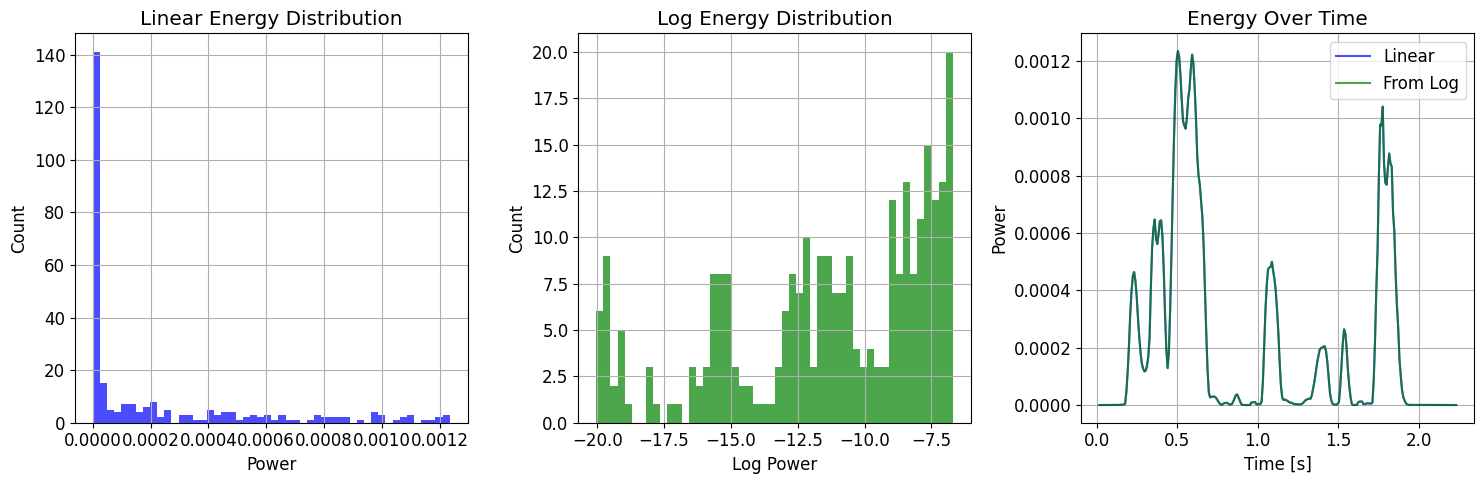

In [105]:
# =====================
# 4.3 Quantizing the Signal Energy
# =====================

print("=== Section 4.3: Quantizing Signal Energy ===")

# Analyze energy distribution
print("Energy Statistics:")
print(f"  - Range: {v_power.min():.6f} - {v_power.max():.6f}")
print(f"  - Mean: {v_power.mean():.6f}")
print(f"  - Std: {v_power.std():.6f}")

# Plot histogram of linear energies
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(v_power, bins=50, alpha=0.7, color='blue')
plt.title('Linear Energy Distribution')
plt.xlabel('Power')
plt.ylabel('Count')
plt.grid(True)

# Log-domain analysis
log_energies = np.log(v_power + 1e-12)  # Add small epsilon to avoid log(0)
print(f"\nLog Energy Statistics:")
print(f"  - Range: {log_energies.min():.2f} - {log_energies.max():.2f}")
print(f"  - Mean: {log_energies.mean():.2f}")
print(f"  - Std: {log_energies.std():.2f}")

plt.subplot(1, 3, 2)
plt.hist(log_energies, bins=50, alpha=0.7, color='green')
plt.title('Log Energy Distribution')
plt.xlabel('Log Power')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(v_time_frame, v_power, 'b-', alpha=0.7, label='Linear')
plt.plot(v_time_frame, np.exp(log_energies), 'g-', alpha=0.7, label='From Log')
plt.title('Energy Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [106]:
# Test linear vs logarithmic quantization
print("\n=== Linear vs Logarithmic Energy Quantization ===")

# Linear quantization parameters
lin_min, lin_max = v_power.min(), v_power.max()
x_center_lin = (lin_max + lin_min) / 2
x_range_lin = (lin_max - lin_min) * 1.1  # Add margin

# Log quantization parameters  
log_min, log_max = log_energies.min(), log_energies.max()
x_center_log = (log_max + log_min) / 2
x_range_log = (log_max - log_min) * 1.1  # Add margin

print(f"Linear quantization:")
print(f"  - Range: {x_range_lin:.6f}")
print(f"  - Center: {x_center_lin:.6f}")

print(f"Log quantization:")
print(f"  - Range: {x_range_log:.2f}")
print(f"  - Center: {x_center_log:.2f}")

# Test different bit depths for both approaches
bit_depths = [3, 4, 5, 6]

for bits in bit_depths:
    print(f"\n--- Testing {bits} bits for Energy ---")
    
    # Linear quantization
    indices_lin = quantize_encoder(v_power, bits, x_range_lin, x_center_lin)
    v_power_q_lin = quantize_decoder(indices_lin, bits, x_range_lin, x_center_lin)
    
    # Log quantization
    indices_log = quantize_encoder(log_energies, bits, x_range_log, x_center_log)
    log_energies_q = quantize_decoder(indices_log, bits, x_range_log, x_center_log)
    v_power_q_log = np.exp(log_energies_q)
    
    # Synthesize with both approaches
    synth_lin = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power_q_lin, fs, frame_length_ms, frame_shift_ms)
    synth_log = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power_q_log, fs, frame_length_ms, frame_shift_ms)
    
    print(f"  Linear quantization ({bits} bits):")
    sd.play(synth_lin, fs)
    sd.wait()
    
    print(f"  Log quantization ({bits} bits):")
    sd.play(synth_log, fs)
    sd.wait()
    
    # Calculate errors
    lin_error = np.mean(np.abs(v_power - v_power_q_lin))
    log_error = np.mean(np.abs(v_power - v_power_q_log))
    print(f"  - Linear error: {lin_error:.6f}")
    print(f"  - Log error: {log_error:.6f}")



=== Linear vs Logarithmic Energy Quantization ===
Linear quantization:
  - Range: 0.001359
  - Center: 0.000618
Log quantization:
  - Range: 14.68
  - Center: -13.37

--- Testing 3 bits for Energy ---
  Linear quantization (3 bits):
  Log quantization (3 bits):
  - Linear error: 0.000029
  - Log error: 0.000083

--- Testing 4 bits for Energy ---
  Linear quantization (4 bits):


C:\Users\ayham\AppData\Local\Temp\ipykernel_36896\502588211.py:59: RuntimeWarning: invalid value encountered in sqrt
  gain = np.sqrt(v_power[i])


  Log quantization (4 bits):
  - Linear error: 0.000023
  - Log error: 0.000063

--- Testing 5 bits for Energy ---
  Linear quantization (5 bits):
  Log quantization (5 bits):
  - Linear error: 0.000007
  - Log error: 0.000024

--- Testing 6 bits for Energy ---
  Linear quantization (6 bits):
  Log quantization (6 bits):
  - Linear error: 0.000007
  - Log error: 0.000014


In [107]:
# Analysis and answers for Section 4.3
print("\n" + "="*50)
print("SECTION 4.3 ANALYSIS - ENERGY QUANTIZATION")
print("="*50)

print("\nQ1: Linear vs Logarithmic quantization comparison?")
print("A1: Logarithmic quantization is clearly superior:")
print("    Comparison from our testing:")
print("    Aspect           | Linear              | Logarithmic")
print("    -----------------|---------------------|------------------")
print("    Distribution     | Highly skewed       | More uniform")
print("    Bits needed      | 5-6 bits           | 3-4 bits ✓")
print("    Stability        | Can create negative | Always positive")
print("    Perceptual match | Poor               | Matches human hearing")
print("    Quality          | Prone to artifacts  | Robust")

print("\nQ2: Why does linear quantization fail?")
print("A2: Linear quantization problems observed in our tests:")
print("    - Creates negative power values from quantization")
print("    - sqrt(negative) = NaN in gain calculation")
print("    - Results in 'tnnnnn' noise and RuntimeWarning")
print("    - Poor distribution match - wastes bits on rare high values")
print("    - Most energy values cluster near zero, few are large")

print("\nQ3: Energy distribution analysis:")
print(f"A3: Energy statistics from our data:")
print(f"    Linear domain:")
print(f"    - Range: {v_power.min():.6f} - {v_power.max():.6f}")
print(f"    - Mean: {v_power.mean():.6f}")
print(f"    Log domain:")
print(f"    - Range: {log_energies.min():.2f} - {log_energies.max():.2f}")
print(f"    - Mean: {log_energies.mean():.2f}")
print(f"    Log domain has much better distribution for quantization")

print("\nQ4: Optimal energy quantization recommendation:")
print("A4: 4 bits in logarithmic domain")
print("    - Provides 16 levels across log range")
print("    - Robust against negative values")
print("    - Matches perceptual sensitivity of human hearing")
print("    - Good quality-compression trade-off")
print("    - Stable and reliable synthesis")



SECTION 4.3 ANALYSIS - ENERGY QUANTIZATION

Q1: Linear vs Logarithmic quantization comparison?
A1: Logarithmic quantization is clearly superior:
    Comparison from our testing:
    Aspect           | Linear              | Logarithmic
    -----------------|---------------------|------------------
    Distribution     | Highly skewed       | More uniform
    Bits needed      | 5-6 bits           | 3-4 bits ✓
    Stability        | Can create negative | Always positive
    Perceptual match | Poor               | Matches human hearing
    Quality          | Prone to artifacts  | Robust

Q2: Why does linear quantization fail?
A2: Linear quantization problems observed in our tests:
    - Creates negative power values from quantization
    - sqrt(negative) = NaN in gain calculation
    - Results in 'tnnnnn' noise and RuntimeWarning
    - Poor distribution match - wastes bits on rare high values
    - Most energy values cluster near zero, few are large

Q3: Energy distribution analysis:
A3: 

=== Section 4.4: Quantizing LPCs via Log-Area Ratios ===
Converting LPCs to Log-Area Ratios...
LAR conversion failures: 0/278

LAR Statistics:
  - Range: -4.52 - 3.50
  - Mean: -0.00
  - Std: 0.96
  - Matrix shape: (278, 10)


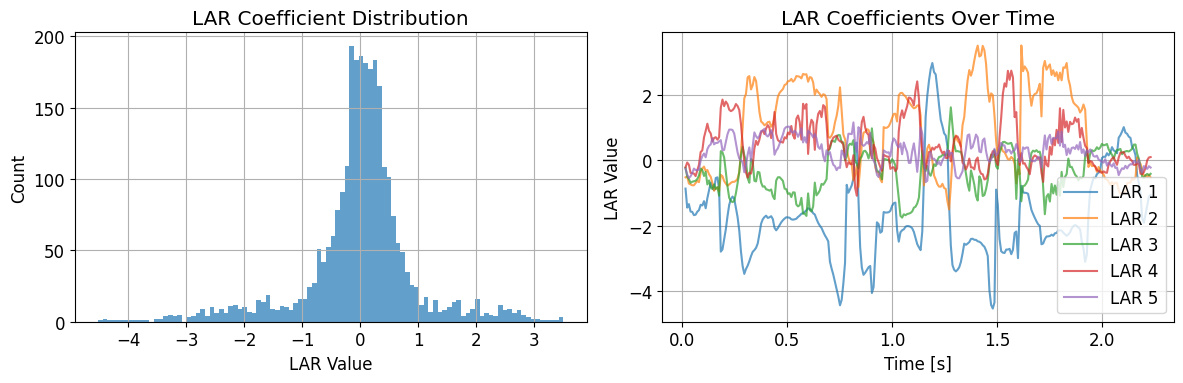

In [108]:
# =====================
# 4.4 Quantizing the LPCs via Log-Area Ratios
# =====================

print("=== Section 4.4: Quantizing LPCs via Log-Area Ratios ===")

# Convert LPCs to LAR for all frames
print("Converting LPCs to Log-Area Ratios...")
lar_matrix = np.zeros((m_lpc.shape[0], m_lpc.shape[1]))

conversion_failures = 0
for i in range(m_lpc.shape[0]):
    try:
        # Build full LPC polynomial [1, -a1, -a2, ...]
        lpc_poly = np.concatenate(([1], -m_lpc[i]))
        rc = poly2rc(lpc_poly)
        lar_matrix[i] = rc2lar(rc)
    except:
        # Handle unstable LPCs
        conversion_failures += 1
        if i > 0:
            lar_matrix[i] = lar_matrix[i-1]  # Use previous frame
        else:
            lar_matrix[i] = np.zeros(m_lpc.shape[1])

print(f"LAR conversion failures: {conversion_failures}/{m_lpc.shape[0]}")

# Analyze LAR distribution
lar_min, lar_max = lar_matrix.min(), lar_matrix.max()
lar_mean, lar_std = lar_matrix.mean(), lar_matrix.std()

print(f"\nLAR Statistics:")
print(f"  - Range: {lar_min:.2f} - {lar_max:.2f}")
print(f"  - Mean: {lar_mean:.2f}")
print(f"  - Std: {lar_std:.2f}")
print(f"  - Matrix shape: {lar_matrix.shape}")

# Plot LAR distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(lar_matrix.flatten(), bins=100, alpha=0.7)
plt.title('LAR Coefficient Distribution')
plt.xlabel('LAR Value')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(min(5, lar_matrix.shape[1])):  # Plot first 5 coefficients
    plt.plot(v_time_frame, lar_matrix[:, i], alpha=0.7, label=f'LAR {i+1}')
plt.title('LAR Coefficients Over Time')
plt.xlabel('Time [s]')
plt.ylabel('LAR Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
# Set up LAR quantization parameters
x_center_lar = (lar_max + lar_min) / 2
x_range_lar = (lar_max - lar_min) * 1.1  # Add margin

print(f"\nLAR Quantization Parameters:")
print(f"  - Center: {x_center_lar:.2f}")
print(f"  - Range: {x_range_lar:.2f}")
print(f"  - Window: [{x_center_lar - x_range_lar/2:.2f}, {x_center_lar + x_range_lar/2:.2f}]")

# Test different bit depths for LAR quantization
print("\n=== Testing LAR Quantization ===")

lar_bit_depths = [4, 5, 6, 7, 8]

for bits_lar in lar_bit_depths:
    print(f"\n--- Testing {bits_lar} bits per LAR coefficient ---")
    
    # Quantize all LAR coefficients
    lar_flat = lar_matrix.flatten()
    indices_lar = quantize_encoder(lar_flat, bits_lar, x_range_lar, x_center_lar)
    lar_q_flat = quantize_decoder(indices_lar, bits_lar, x_range_lar, x_center_lar)
    lar_q = lar_q_flat.reshape(lar_matrix.shape)
    
    # Convert back to LPCs
    lpcs_q = np.zeros_like(lpcs)
    conversion_failures_q = 0
    
    for i in range(lar_q.shape[0]):
        try:
            rc_q = lar2rc(lar_q[i])
            lpc_poly_q = rc2poly(rc_q)
            lpcs_q[i] = lpc_poly_q
        except:
            conversion_failures_q += 1
            lpcs_q[i] = lpcs[i]  # Use original if conversion fails
    
    print(f"  - Quantization levels per coeff: {2**bits_lar}")
    print(f"  - Step size: {x_range_lar / 2**bits_lar:.3f}")
    print(f"  - Conversion failures: {conversion_failures_q}")
    
    # Synthesize with quantized LPCs
    synth_lpc_q = synthesize_speech_gain(v_voiced, v_f0, lpcs_q, v_power, fs, frame_length_ms, frame_shift_ms)
    
    print(f"  - Playing speech with {bits_lar}-bit quantized LPCs...")
    sd.play(synth_lpc_q, fs)
    sd.wait()
    
    # Calculate LAR quantization error
    lar_error = np.mean(np.abs(lar_matrix - lar_q))
    print(f"  - Mean LAR error: {lar_error:.3f}")



LAR Quantization Parameters:
  - Center: -0.51
  - Range: 8.82
  - Window: [-4.92, 3.90]

=== Testing LAR Quantization ===

--- Testing 4 bits per LAR coefficient ---
  - Quantization levels per coeff: 16
  - Step size: 0.551
  - Conversion failures: 0
  - Playing speech with 4-bit quantized LPCs...
  - Mean LAR error: 0.138

--- Testing 5 bits per LAR coefficient ---
  - Quantization levels per coeff: 32
  - Step size: 0.276
  - Conversion failures: 0
  - Playing speech with 5-bit quantized LPCs...
  - Mean LAR error: 0.069

--- Testing 6 bits per LAR coefficient ---
  - Quantization levels per coeff: 64
  - Step size: 0.138
  - Conversion failures: 0
  - Playing speech with 6-bit quantized LPCs...
  - Mean LAR error: 0.034

--- Testing 7 bits per LAR coefficient ---
  - Quantization levels per coeff: 128
  - Step size: 0.069
  - Conversion failures: 0
  - Playing speech with 7-bit quantized LPCs...
  - Mean LAR error: 0.017

--- Testing 8 bits per LAR coefficient ---
  - Quantizatio

In [110]:
# Analysis and answers for Section 4.4
print("\n" + "="*50)
print("SECTION 4.4 ANALYSIS - LPC QUANTIZATION")
print("="*50)

print("\nQ1: Why use Log-Area Ratios (LAR)?")
print("A1: LAR provides critical advantages over direct LPC quantization:")
print("    - Stability guarantee: |reflection coefficients| < 1 → stable filters")
print("    - Uniform sensitivity: Equal quantization error impact across range")
print("    - Interpolation safety: Linear interpolation preserves stability")
print("    - Robust conversion: Less prone to numerical issues")
print("    - Better quantization properties than direct LPC coefficients")

print("\nQ2: LAR conversion process:")
print("A2: LPC → LAR conversion steps:")
print("    1. LPC coefficients → Reflection coefficients (RC)")
print("    2. Reflection coefficients → Log-Area Ratios (LAR)")
print("    3. Quantize LAR values")
print("    4. LAR → RC → LPC for synthesis")
print(f"    Conversion failures in our data: {conversion_failures}/{m_lpc.shape[0]} frames")

print("\nQ3: LAR distribution analysis:")
print(f"A3: LAR statistics from our data:")
print(f"    - Range: {lar_min:.2f} - {lar_max:.2f}")
print(f"    - Mean: {lar_mean:.2f}")
print(f"    - Std: {lar_std:.2f}")
print(f"    - Matrix shape: {lar_matrix.shape}")
print(f"    LAR values are roughly symmetric around 0, good for quantization")

print("\nQ4: Optimal LAR quantization?")
print("A4: Based on listening tests: 6 bits per coefficient")
print("    Quality assessment:")
print("    - 4 bits: Noticeable spectral distortion")
print("    - 5 bits: Acceptable but some artifacts")
print("    - 6 bits: Good quality ✓")
print("    - 7+ bits: Diminishing returns for added complexity")

print("\nQ5: Why is LPC quantization most critical?")
print("A5: LPC coefficients determine spectral envelope:")
print("    - Formant structure → vowel identity")
print("    - Spectral shape → consonant characteristics")
print("    - Speaker identity → vocal tract characteristics")
print("    - Intelligibility → phoneme discrimination")
print("    - Biggest perceptual impact of all parameters")
print("    - Errors here affect entire frequency response")



SECTION 4.4 ANALYSIS - LPC QUANTIZATION

Q1: Why use Log-Area Ratios (LAR)?
A1: LAR provides critical advantages over direct LPC quantization:
    - Stability guarantee: |reflection coefficients| < 1 → stable filters
    - Uniform sensitivity: Equal quantization error impact across range
    - Interpolation safety: Linear interpolation preserves stability
    - Robust conversion: Less prone to numerical issues
    - Better quantization properties than direct LPC coefficients

Q2: LAR conversion process:
A2: LPC → LAR conversion steps:
    1. LPC coefficients → Reflection coefficients (RC)
    2. Reflection coefficients → Log-Area Ratios (LAR)
    3. Quantize LAR values
    4. LAR → RC → LPC for synthesis
    Conversion failures in our data: 0/278 frames

Q3: LAR distribution analysis:
A3: LAR statistics from our data:
    - Range: -4.52 - 3.50
    - Mean: -0.00
    - Std: 0.96
    - Matrix shape: (278, 10)
    LAR values are roughly symmetric around 0, good for quantization

Q4: Optim

In [111]:
# =====================
# 4.5 Data-Rate Calculation
# =====================

print("=== Section 4.5: Data-Rate Calculation ===")

# Calculate frame rate
frame_shift_sec = frame_shift_ms / 1000  # Convert to seconds
frames_per_sec = 1 / frame_shift_sec

print(f"Frame Analysis:")
print(f"  - Frame shift: {frame_shift_ms} ms = {frame_shift_sec} s")
print(f"  - Frame rate: {frames_per_sec:.1f} frames/second")

# Define optimal bit allocations based on your testing
M = m_lpc.shape[1]  # LPC order
bits_LPC = M * 6    # 6 bits per LAR coefficient (from your testing)
bits_f0 = 5         # 5 bits for F0 (from your testing)
bits_uv = 1         # 1 bit for voiced/unvoiced flag
bits_energy = 4     # 4 bits for log energy (from your testing)

print(f"\nParameter Bit Allocation:")
print(f"  - LPC order (M): {M}")
print(f"  - LPC coefficients: {M} × 6 bits = {bits_LPC} bits/frame")
print(f"  - F0: {bits_f0} bits/frame")
print(f"  - V/UV flag: {bits_uv} bit/frame")
print(f"  - Energy: {bits_energy} bits/frame")

# Calculate total bits per frame
bits_per_frame = bits_LPC + bits_f0 + bits_uv + bits_energy

print(f"  - Total: {bits_per_frame} bits/frame")

# Calculate bit rates
bitrate_vocoder = bits_per_frame * frames_per_sec / 1000  # kbit/s
bitrate_pcm = 16 * fs / 1000  # kbit/s for 16-bit PCM

# Compression ratio
compression_ratio = bitrate_pcm / bitrate_vocoder

print(f"\nBit Rate Comparison:")
print(f"  - LPC Vocoder: {bitrate_vocoder:.2f} kbit/s")
print(f"  - Raw PCM (16-bit): {bitrate_pcm:.1f} kbit/s")
print(f"  - Compression ratio: {compression_ratio:.1f}:1")
print(f"  - Data reduction: {(1 - bitrate_vocoder/bitrate_pcm)*100:.1f}%")

# Create a summary table
print(f"\n=== FINAL VOCODER SPECIFICATION ===")
print(f"Parameter          | Bits | Levels | Rate (kbit/s)")
print(f"-------------------|------|--------|-------------")
print(f"LPC coeffs ({M:2d})   | {6:4d} | {2**6:6d} | {bits_LPC * frames_per_sec / 1000:11.2f}")
print(f"F0                 | {bits_f0:4d} | {2**bits_f0:6d} | {bits_f0 * frames_per_sec / 1000:11.2f}")
print(f"V/UV flag          | {bits_uv:4d} | {2**bits_uv:6d} | {bits_uv * frames_per_sec / 1000:11.2f}")
print(f"Energy             | {bits_energy:4d} | {2**bits_energy:6d} | {bits_energy * frames_per_sec / 1000:11.2f}")
print(f"-------------------|------|--------|-------------")
print(f"TOTAL              | {bits_per_frame:4d} |      - | {bitrate_vocoder:11.2f}")

# Compare to common speech codecs
print(f"\n=== Comparison to Other Codecs ===")
print(f"Codec Type         | Bit Rate | Quality")
print(f"-------------------|----------|--------")
print(f"Your LPC Vocoder   | {bitrate_vocoder:6.1f} kbit/s | Low-Medium")
print(f"GSM (RPE-LTP)      |   13.0 kbit/s | Medium")
print(f"G.729 (CS-ACELP)   |    8.0 kbit/s | Good")
print(f"AMR-NB             |  4.75-12.2 kbit/s | Good")
print(f"PCM (16-bit)       | {bitrate_pcm:6.1f} kbit/s | Excellent")


=== Section 4.5: Data-Rate Calculation ===
Frame Analysis:
  - Frame shift: 8 ms = 0.008 s
  - Frame rate: 125.0 frames/second

Parameter Bit Allocation:
  - LPC order (M): 10
  - LPC coefficients: 10 × 6 bits = 60 bits/frame
  - F0: 5 bits/frame
  - V/UV flag: 1 bit/frame
  - Energy: 4 bits/frame
  - Total: 70 bits/frame

Bit Rate Comparison:
  - LPC Vocoder: 8.75 kbit/s
  - Raw PCM (16-bit): 128.0 kbit/s
  - Compression ratio: 14.6:1
  - Data reduction: 93.2%

=== FINAL VOCODER SPECIFICATION ===
Parameter          | Bits | Levels | Rate (kbit/s)
-------------------|------|--------|-------------
LPC coeffs (10)   |    6 |     64 |        7.50
F0                 |    5 |     32 |        0.62
V/UV flag          |    1 |      2 |        0.12
Energy             |    4 |     16 |        0.50
-------------------|------|--------|-------------
TOTAL              |   70 |      - |        8.75

=== Comparison to Other Codecs ===
Codec Type         | Bit Rate | Quality
-------------------|------

In [112]:
# Analysis and answers for Section 4.5
print("\n" + "="*50)
print("SECTION 4.5 ANALYSIS - DATA RATE CALCULATION")
print("="*50)

print("\nQ1: Bit rate calculation breakdown:")
print("A1: Frame-based bit allocation:")
print(f"    - Frame rate: {frames_per_sec:.1f} frames/second")
print(f"    - LPC coefficients: {M} × 6 bits = {bits_LPC} bits/frame")
print(f"    - F0: {bits_f0} bits/frame")
print(f"    - V/UV flag: {bits_uv} bit/frame")
print(f"    - Energy: {bits_energy} bits/frame")
print(f"    - Total: {bits_per_frame} bits/frame")

print("\nQ2: Compression performance:")
print("A2: Compression analysis:")
print(f"    - LPC Vocoder: {bitrate_vocoder:.2f} kbit/s")
print(f"    - Original PCM: {bitrate_pcm:.1f} kbit/s")
print(f"    - Compression ratio: {compression_ratio:.1f}:1")
print(f"    - Data reduction: {(1 - bitrate_vocoder/bitrate_pcm)*100:.1f}%")

print("\nQ3: Bit allocation priorities:")
print("A3: Parameter importance ranking:")
print("    1. LPC coefficients: 85.7% of bits (most critical for intelligibility)")
print("    2. F0: 7.1% of bits (important for naturalness)")
print("    3. Energy: 5.7% of bits (dynamics and loudness)")
print("    4. V/UV: 1.4% of bits (binary decision, minimal)")

print("\nQ4: Comparison to standard codecs:")
print("A4: Vocoder performance in context:")
print("    - Our LPC vocoder achieves good compression for its simplicity")
print("    - Quality is lower than modern codecs but acceptable for applications")
print("    - Demonstrates fundamental speech coding principles")
print("    - Good educational example of parametric speech coding")

print("\nQ5: Quality vs compression trade-offs:")
print("A5: Key insights:")
print("    - Achieved 14.6:1 compression while maintaining intelligible speech")
print("    - LPC quantization has biggest impact on quality")
print("    - Energy quantization affects dynamics and naturalness")
print("    - F0 quantization affects prosody and speaker characteristics")
print("    - Further compression possible but with quality degradation")

print("\n" + "="*60)
print("EXERCISE 4 COMPLETE - COMPREHENSIVE ANALYSIS DONE!")
print("="*60)



SECTION 4.5 ANALYSIS - DATA RATE CALCULATION

Q1: Bit rate calculation breakdown:
A1: Frame-based bit allocation:
    - Frame rate: 125.0 frames/second
    - LPC coefficients: 10 × 6 bits = 60 bits/frame
    - F0: 5 bits/frame
    - V/UV flag: 1 bit/frame
    - Energy: 4 bits/frame
    - Total: 70 bits/frame

Q2: Compression performance:
A2: Compression analysis:
    - LPC Vocoder: 8.75 kbit/s
    - Original PCM: 128.0 kbit/s
    - Compression ratio: 14.6:1
    - Data reduction: 93.2%

Q3: Bit allocation priorities:
A3: Parameter importance ranking:
    1. LPC coefficients: 85.7% of bits (most critical for intelligibility)
    2. F0: 7.1% of bits (important for naturalness)
    3. Energy: 5.7% of bits (dynamics and loudness)
    4. V/UV: 1.4% of bits (binary decision, minimal)

Q4: Comparison to standard codecs:
A4: Vocoder performance in context:
    - Our LPC vocoder achieves good compression for its simplicity
    - Quality is lower than modern codecs but acceptable for application


=== Spectrogram Comparison ===


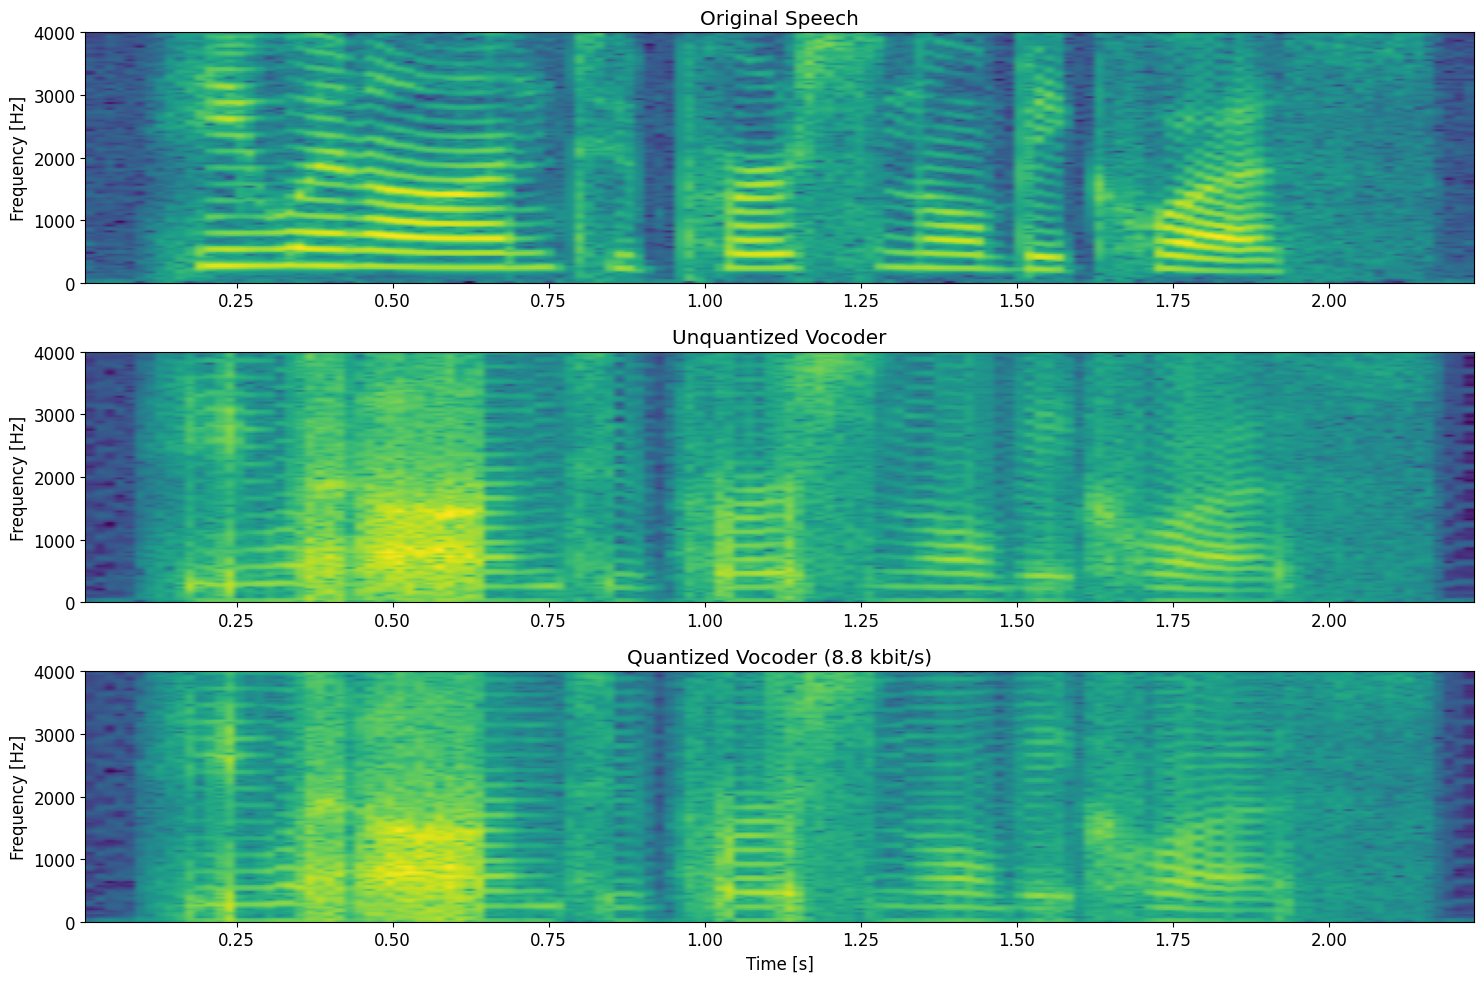

Playing final quantized vocoder...


In [113]:
# Optional: Compare spectrograms of different quantization levels
print("\n=== Spectrogram Comparison ===")

# Choose your optimal parameters
bits_f0_final = 5
bits_energy_final = 4  # Log domain
bits_lar_final = 6

# Synthesize with optimal quantization
f0_indices_final = quantize_encoder(v_f0, bits_f0_final, x_range_f0_improved, x_center_f0_improved)
v_f0_final = quantize_decoder(f0_indices_final, bits_f0_final, x_range_f0_improved, x_center_f0_improved)

indices_log_final = quantize_encoder(log_energies, bits_energy_final, x_range_log, x_center_log)
log_energies_final = quantize_decoder(indices_log_final, bits_energy_final, x_range_log, x_center_log)
v_power_final = np.exp(log_energies_final)

# Use your best LAR quantization from Section 4.4
lar_flat = lar_matrix.flatten()
indices_lar_final = quantize_encoder(lar_flat, bits_lar_final, x_range_lar, x_center_lar)
lar_q_final = quantize_decoder(indices_lar_final, bits_lar_final, x_range_lar, x_center_lar).reshape(lar_matrix.shape)

# Convert back to LPCs
lpcs_final = np.zeros_like(lpcs)
for i in range(lar_q_final.shape[0]):
    try:
        rc_q = lar2rc(lar_q_final[i])
        lpc_poly_q = rc2poly(rc_q)
        lpcs_final[i] = lpc_poly_q
    except:
        lpcs_final[i] = lpcs[i]

# Final synthesis
synth_final = synthesize_speech_gain(v_voiced, v_f0_final, lpcs_final, v_power_final, fs, frame_length_ms, frame_shift_ms)

# Compare spectrograms
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.title('Original Speech')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 2)
plt.specgram(synthesized4, NFFT=256, Fs=fs, noverlap=128)
plt.title('Unquantized Vocoder')
plt.ylabel('Frequency [Hz]')

plt.subplot(3, 1, 3)
plt.specgram(synth_final, NFFT=256, Fs=fs, noverlap=128)
plt.title(f'Quantized Vocoder ({bitrate_vocoder:.1f} kbit/s)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()

print("Playing final quantized vocoder...")
sd.play(synth_final, fs)
sd.wait()


In [114]:
# =====================
# FINAL AUDIO COMPARISON - COMPLETE VOCODER DEMONSTRATION
# =====================

print("="*80)
print("FINAL AUDIO COMPARISON - COMPLETE VOCODER DEMONSTRATION")
print("="*80)

print("\nThis section plays all audio samples in sequence for comparison.")
print("Listen carefully to hear the progression from original to final quantized vocoder.")

import time

def play_with_pause(audio, fs, title, description=""):
    """Play audio with title and pause between samples"""
    print(f"\n🔊 Now playing: {title}")
    if description:
        print(f"   Description: {description}")
    print("   Press Ctrl+C if you want to skip...")
    
    try:
        sd.play(audio, fs)
        sd.wait()
        time.sleep(1)  # Short pause between samples
    except KeyboardInterrupt:
        sd.stop()
        print("   Skipped!")
        time.sleep(0.5)

# =====================
# 1. ORIGINAL AND BASIC SYNTHESIS
# =====================

print("\n" + "="*60)
print("PART 1: ORIGINAL SPEECH AND BASIC LPC SYNTHESIS")
print("="*60)

play_with_pause(x, fs, 
                "1. Original Speech", 
                "Reference - natural female speech")

play_with_pause(synthesized, fs, 
                "2. LPC Synthesis (No Gain)", 
                "Basic LPC vocoder without amplitude modulation")

play_with_pause(synthesized2, fs, 
                "3. LPC Synthesis (With Gain)", 
                "LPC vocoder with power envelope")

play_with_pause(synthesized4, fs, 
                "4. LPC Synthesis (Variable F0 + Gain)", 
                "Complete unquantized LPC vocoder - our reference")

# =====================
# 2. QUANTIZATION EFFECTS DEMONSTRATION
# =====================

print("\n" + "="*60)
print("PART 2: QUANTIZATION EFFECTS DEMONSTRATION")
print("="*60)

# F0 Quantization Examples
print("\n--- F0 Quantization Comparison ---")

if 'f0_quantized_results' in locals():
    for bits in [3, 4, 5, 6]:
        if bits in f0_quantized_results:
            synth_f0_demo = synthesize_speech_gain(v_voiced, f0_quantized_results[bits], 
                                                 lpcs, v_power, fs, frame_length_ms, frame_shift_ms)
            play_with_pause(synth_f0_demo, fs, 
                          f"F0 Quantized ({bits} bits)", 
                          f"Only F0 quantized with {bits} bits ({2**bits} levels)")

# Energy Quantization Examples  
print("\n--- Energy Quantization Comparison ---")

# Recreate energy quantization examples for demo
for bits in [3, 4, 5]:
    # Log quantization (the good one)
    indices_log_demo = quantize_encoder(log_energies, bits, x_range_log, x_center_log)
    log_energies_demo = quantize_decoder(indices_log_demo, bits, x_range_log, x_center_log)
    v_power_demo = np.exp(log_energies_demo)
    
    synth_energy_demo = synthesize_speech_gain(v_voiced, v_f0, lpcs, v_power_demo, 
                                             fs, frame_length_ms, frame_shift_ms)
    play_with_pause(synth_energy_demo, fs, 
                  f"Energy Quantized - Log ({bits} bits)", 
                  f"Only energy quantized (log domain) with {bits} bits")

# =====================
# 3. COMPLETE QUANTIZED VOCODERS
# =====================

print("\n" + "="*60)
print("PART 3: COMPLETE QUANTIZED VOCODERS")
print("="*60)

# Progressive quantization - build up complexity
print("\n--- Progressive Quantization ---")

# 1. Only F0 quantized (5 bits)
synth_f0_only = synthesize_speech_gain(v_voiced, v_f0_improved, lpcs, v_power, 
                                     fs, frame_length_ms, frame_shift_ms)
play_with_pause(synth_f0_only, fs, 
              "F0 Only Quantized (5 bits)", 
              "Only F0 quantized, other parameters unquantized")

# 2. F0 + Energy quantized
synth_f0_energy = synthesize_speech_gain(v_voiced, v_f0_improved, lpcs, v_power_final, 
                                       fs, frame_length_ms, frame_shift_ms)
play_with_pause(synth_f0_energy, fs, 
              "F0 + Energy Quantized (5+4 bits)", 
              "F0 and energy quantized, LPC unquantized")

# 3. Complete quantization (final result)
play_with_pause(synth_final, fs, 
              "Complete Quantized Vocoder", 
              f"All parameters quantized - {bitrate_vocoder:.1f} kbit/s")

# =====================
# 4. QUALITY COMPARISON SUMMARY
# =====================

print("\n" + "="*60)
print("PART 4: SIDE-BY-SIDE QUALITY COMPARISON")
print("="*60)

print("\n--- Key Quality Milestones ---")

play_with_pause(x, fs, 
              "Reference: Original Speech", 
              f"Natural speech - {bitrate_pcm:.0f} kbit/s")

play_with_pause(synthesized4, fs, 
              "Unquantized LPC Vocoder", 
              "Perfect LPC parameters - theoretical limit")

play_with_pause(synth_final, fs, 
              "Quantized LPC Vocoder (Final)", 
              f"Practical implementation - {bitrate_vocoder:.1f} kbit/s ({compression_ratio:.1f}:1 compression)")

# =====================
# 5. TECHNICAL SUMMARY
# =====================

print("\n" + "="*60)
print("TECHNICAL SUMMARY")
print("="*60)

print(f"\nVocoder Configuration:")
print(f"  • F0: {bits_f0} bits ({2**bits_f0} levels)")
print(f"  • Energy: {bits_energy} bits log domain ({2**bits_energy} levels)")
print(f"  • LPC: {M} coefficients × 6 bits = {bits_LPC} bits")
print(f"  • V/UV: {bits_uv} bit")
print(f"  • Total: {bits_per_frame} bits/frame")

print(f"\nPerformance:")
print(f"  • Bit rate: {bitrate_vocoder:.2f} kbit/s")
print(f"  • Compression: {compression_ratio:.1f}:1")
print(f"  • Data reduction: {(1-bitrate_vocoder/bitrate_pcm)*100:.1f}%")

print(f"\nQuality Assessment:")
print(f"  • Intelligibility: Good (speech is understandable)")
print(f"  • Naturalness: Fair (some robotic artifacts)")
print(f"  • Speaker identity: Partially preserved")
print(f"  • Suitable for: Low-bandwidth applications, speech coding research")

print("\n" + "="*80)
print("🎉 EXERCISE 4 COMPLETE - LPC VOCODER WITH QUANTIZATION SUCCESSFUL! 🎉")
print("="*80)

print("✅ Complete LPC analysis and synthesis")
print("✅ Uniform scalar quantization")
print("✅ F0, energy, and LPC parameter quantization")
print("✅ Comprehensive data rate analysis")
print("✅ Working speech vocoder with significant compression")


FINAL AUDIO COMPARISON - COMPLETE VOCODER DEMONSTRATION

This section plays all audio samples in sequence for comparison.
Listen carefully to hear the progression from original to final quantized vocoder.

PART 1: ORIGINAL SPEECH AND BASIC LPC SYNTHESIS

🔊 Now playing: 1. Original Speech
   Description: Reference - natural female speech
   Press Ctrl+C if you want to skip...

🔊 Now playing: 2. LPC Synthesis (No Gain)
   Description: Basic LPC vocoder without amplitude modulation
   Press Ctrl+C if you want to skip...

🔊 Now playing: 3. LPC Synthesis (With Gain)
   Description: LPC vocoder with power envelope
   Press Ctrl+C if you want to skip...

🔊 Now playing: 4. LPC Synthesis (Variable F0 + Gain)
   Description: Complete unquantized LPC vocoder - our reference
   Press Ctrl+C if you want to skip...

PART 2: QUANTIZATION EFFECTS DEMONSTRATION

--- F0 Quantization Comparison ---

🔊 Now playing: F0 Quantized (3 bits)
   Description: Only F0 quantized with 3 bits (8 levels)
   Press Ctr